# Imports:

In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [3]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from mne.decoding import CSP
from sklearn.metrics import classification_report, confusion_matrix
import copy
import sys, os
import pandas as pd
import time
from scipy import signal
import scipy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#import torch
#from torch import nn
from sklearn.metrics import classification_report
from contextlib import redirect_stdout, redirect_stderr
import io
import pickle
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import random
#from torchsummary import summary
#import torchinfo
#import moabb

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Parameter tunning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from scikeras.wrappers import KerasClassifier



import json

In [4]:
# projects/def-b09sdp/bijan/Phase2/P16.fdt
path = !pwd
path

['/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI']

# Functions:

In [5]:
def data_wrapper(data_epochs, data_labels, mode='binary'):
    
    if mode == 'binary':
        epochs = []
        labels = []

        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            binary_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2)]
            #class2_epochs = participant_epochs[participant_labels==2]
            #bi_epochs = np.concatenate((class1_epochs, class2_epochs), axis=0)
            epochs.append(binary_epochs)
    
            binary_labels = participant_labels[(participant_labels==1) | (participant_labels==2)]
            #bi_labels = np.concatenate((class1_labels, class2_labels), axis=0)
            labels.append(binary_labels)
            
    elif mode == '3_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            labels.append(multiclass_labels)
            
            
    elif mode == '4_class_RS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
        
    elif mode == '4_class_LS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
    elif mode == '6_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            labels.append(multiclass_labels)
    
    return epochs, labels

In [6]:
def epoch_label_extractor(data, events, epoch_length, num_channels, sampling_freq):
    
    data = data.to_data_frame()
    events = events[0]
    third_column = events[:, 2]
    mask = np.isin(third_column, [7, 8, 9, 10])
    MI_events = events[mask]
    
    number_of_epochs = MI_events.shape[0]
    labels = np.zeros((number_of_epochs,1)).astype(int)
    epochs = np.zeros((number_of_epochs, num_channels, epoch_length * sampling_freq))
    index = 0
    for index in range(number_of_epochs):
        start = int(MI_events[index, 0])
        end = int(MI_events[index, 0]) + epoch_length * sampling_freq
        all_channels = data.iloc[start:end]
        epochs[index,:,:] = all_channels[all_channels.columns[1: num_channels+1]].T
        
        # Because it is numbered form 7 to 10 !!!
        labels[index] = MI_events[index, 2] - 7

            
    return epochs, labels

In [7]:
def epoch_label_extractor(Data, epoch_length=1123, num_channels=64):
    df = Data.to_data_frame()
    X = df[df.columns[3:]].to_numpy()
    X = np.transpose(X)

    number_of_epochs = int(len(df)/epoch_length)
    
    randomlist = random.sample(range(number_of_epochs), number_of_epochs)

    data = np.zeros((number_of_epochs,num_channels, epoch_length))
    labels = np.zeros((number_of_epochs,1)).astype(int)

    for i in range(number_of_epochs):
        data[i,:,:] = X[:, randomlist[i]*epoch_length:(randomlist[i] + 1)*epoch_length]
        if (df['condition'][randomlist[i]*epoch_length] == 'Left'):
            labels[i,0] = 0
        elif(df['condition'][randomlist[i]*epoch_length] == 'Right'):
            labels[i,0] = 1
        elif(df['condition'][randomlist[i]*epoch_length] == 'Feet'):
            labels[i,0] = 2
        elif(df['condition'][randomlist[i]*epoch_length] == 'Tongue'):
            labels[i,0] = 3
        elif(df['condition'][randomlist[i]*epoch_length] == 'Mis'):
            labels[i,0] = 4
        elif(df['condition'][randomlist[i]*epoch_length] == 'Si'):
            labels[i,0] = 5
        else:
            labels[i,0] = 6
        
    return data, labels

In [8]:
def encoder(y_data, method=OneHotEncoder):
    
    encoder = OneHotEncoder()
    encoder.fit(y_data[0].reshape(-1, 1))
    
    for i in range(len(y_data)):
        
        a = encoder.transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [9]:
def class_extraction(classes, data, labels):
    mask = np.isin(labels[:, 0], classes)
    dataset = data[mask, :, :]
    Final_labels = labels[mask, :]
    return dataset, Final_labels

In [10]:
def calc_csp(x_train, y_train, x_test, n_components=16):
    
        csp = CSP(n_components)
        csp_fit = csp.fit(x_train, y_train)
        train_feat = csp_fit.transform(x_train)
        test_feat = csp_fit.transform(x_test)
        return train_feat, test_feat

In [11]:
def feature_extraction_4(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, filter_length=50)
        filtered_data_test = mne.filter.filter_data(data_test, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [12]:
def feature_extraction_cheby2(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(15, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [13]:
def Preprocess_validator(train_data, train_labels, test_data, sampling_freq, n_components=2):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(40, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features, filtered_data.reshape((n_epochs_train, n_split, n_channels, n_samples))

# Device (GPU\CPU\MPS)

In [14]:

if tf.config.list_physical_devices('GPU'):
    device = "cuda"
else:
    # Check if TensorFlow Multi-Process Service (MPS) is available
    if tf.config.experimental.list_physical_devices('MPS'):
        device = "mps"
    else:
        device = "cpu"

print(f"Using {device} device")


Using cuda device


# EEG-TCNet Model:

In [15]:
def TCN_block(input_layer,input_dimension,depth,kernel_size,filters,dropout,activation='relu'):
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(input_layer)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    if(input_dimension != filters):
        conv = Conv1D(filters,kernel_size=1,padding='same')(input_layer)
        added = Add()([block,conv])
    else:
        added = Add()([block,input_layer])
    out = Activation(activation)(added)
    
    for i in range(depth-1):
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(out)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        added = Add()([block, out])
        out = Activation(activation)(added)
        
    return out



def EEGNet(input_layer,F1=4,kernLength=64,D=2,Chans=22,dropout=0.1):
    F2= F1*D
    block1 = Conv2D(F1, (kernLength, 1), padding = 'same',data_format='channels_last',use_bias = False)(input_layer)
    block1 = BatchNormalization(axis = -1)(block1)
    block2 = DepthwiseConv2D((1, Chans), use_bias = False, 
                                    depth_multiplier = D,
                                    data_format='channels_last',
                                    depthwise_constraint = max_norm(1.))(block1)
    block2 = BatchNormalization(axis = -1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8,1),data_format='channels_last')(block2)
    block2 = Dropout(dropout)(block2)
    block3 = SeparableConv2D(F2, (16, 1),
                            data_format='channels_last',
                            use_bias = False, padding = 'same')(block2)
    block3 = BatchNormalization(axis = -1)(block3)
    block3 = Activation('elu')(block3)
    block3 = AveragePooling2D((8,1),data_format='channels_last')(block3)
    block3 = Dropout(dropout)(block3)
    return block3




def EEGTCNet(nb_classes,Chans=64, Samples=128, layers=3, kernel_s=10,filt=10, dropout=0, activation='relu', F1=4, D=2, kernLength=64, dropout_eeg=0.1):
    input1 = Input(shape = (1,Chans, Samples))
    input2 = Permute((3,2,1))(input1)
    regRate=.25
    numFilters = F1
    F2= numFilters*D

    EEGNet_sep = EEGNet(input_layer=input2,F1=F1,kernLength=kernLength,D=D,Chans=Chans,dropout=dropout_eeg)
    block2 = Lambda(lambda x: x[:,:,-1,:])(EEGNet_sep)
    outs = TCN_block(input_layer=block2,input_dimension=F2,depth=layers,kernel_size=kernel_s,filters=filt,dropout=dropout,activation=activation)
    out = Lambda(lambda x: x[:,-1,:])(outs)
    dense        = Dense(nb_classes, name = 'dense',kernel_constraint = max_norm(regRate))(out)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1,outputs=softmax)

In [16]:
nb_classes=4

model = EEGTCNet(nb_classes=nb_classes, Chans=64, Samples=1123, layers=3, kernel_s=10,filt=10, dropout=0, activation='relu', F1=4, D=2, kernLength=64, dropout_eeg=0.1)
model.summary()

2024-04-30 15:33:00.788463: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 15:33:03.979259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13625 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-04-30 15:33:04.001835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13625 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:5f:00.0, compute capability: 7.5
2024-04-30 15:33:04.004140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 1362

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 64, 1123  0           []                               
                                )]                                                                
                                                                                                  
 permute (Permute)              (None, 1123, 64, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 1123, 64, 4)  256         ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1123, 64, 4)  16         ['conv2d[0][0]']             

# Data reading:

In [17]:
path[0]

'/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI'

In [18]:
try: 
    if path[0] == '/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI':
        print("Running on cloud ...")
        print("Please make sure to modify how you read the data according to your need!\n\n")
        raw_data_path = "/home/bijan/projects/def-b09sdp/bijan/Phase1"
        
    elif path[0] == "'pwd' is not recognized as an internal or external command,":
        print("Running local ...")
        print("Please make sure to change the data path!\n\n")
        raw_data_path = "D:\Hadi_BCI\Recordings\Phase 1\PreProcessedData\P2toP15"
        
except NameError:
    print("Running local ...")
    print("Please make sure to change the data path!\n\n")
    raw_data_path = "D:\Hadi_BCI\Recordings\Phase 1\PreProcessedData\P2toP15"
    
    

data_epochs = []
data_labels = []
all_data_epochs = []
all_data_labels = []

for participant_id in range(2, 16):
    
    participant_T = f"P{participant_id}"
    file_path_T = f"{raw_data_path}/{participant_T}.set"

    raw_data = mne.read_epochs_eeglab(file_path_T)


    epochs, labels = epoch_label_extractor(raw_data, epoch_length=1123, num_channels=64)
    
    class_1=0
    class_2=1 
    class_3=2
    class_4=3
    classes = [class_1, class_2, class_3, class_4]
    num_channels = 64
    epoch_length = 1123
    
    data_epochs, data_labels = class_extraction(classes, epochs, labels)
    
    all_data_epochs.append(data_epochs)
    all_data_labels.append(data_labels)


Running on cloud ...
Please make sure to modify how you read the data according to your need!


Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P2.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P3.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)
/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Channel names are not unique, found duplicates for: {'FCz'}. Applying running numbers for duplicates.
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
488 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P4.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)
/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Channel names are not unique, found duplicates for: {'FCz'}. Applying running numbers for duplicates.
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
491 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P5.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
489 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P6.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
489 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P7.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P8.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P9.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P10.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P11.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P12.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P13.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
488 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P14.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P15.set...


/tmp/ipykernel_152992/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [19]:
for i in range(9):
    print("Subject {} train epochs:    ".format(i+1), all_data_epochs[i].shape, "    Subject {} train labels:    ".format(i+1), all_data_labels[i].shape)


Subject 1 train epochs:     (280, 64, 1123)     Subject 1 train labels:     (280, 1)
Subject 2 train epochs:     (278, 64, 1123)     Subject 2 train labels:     (278, 1)
Subject 3 train epochs:     (280, 64, 1123)     Subject 3 train labels:     (280, 1)
Subject 4 train epochs:     (279, 64, 1123)     Subject 4 train labels:     (279, 1)
Subject 5 train epochs:     (279, 64, 1123)     Subject 5 train labels:     (279, 1)
Subject 6 train epochs:     (280, 64, 1123)     Subject 6 train labels:     (280, 1)
Subject 7 train epochs:     (280, 64, 1123)     Subject 7 train labels:     (280, 1)
Subject 8 train epochs:     (160, 64, 1123)     Subject 8 train labels:     (160, 1)
Subject 9 train epochs:     (280, 64, 1123)     Subject 9 train labels:     (280, 1)


In [20]:
for i in range(len(all_data_epochs)):
    all_data_epochs[i] = np.expand_dims(all_data_epochs[i], 1)
    print("All data epoch shape (sub {}):    ".format(i), all_data_epochs[i].shape, "    All label shape (sub {}):     ".format(i), all_data_labels[i].shape)

All data epoch shape (sub 0):     (280, 1, 64, 1123)     All label shape (sub 0):      (280, 1)
All data epoch shape (sub 1):     (278, 1, 64, 1123)     All label shape (sub 1):      (278, 1)
All data epoch shape (sub 2):     (280, 1, 64, 1123)     All label shape (sub 2):      (280, 1)
All data epoch shape (sub 3):     (279, 1, 64, 1123)     All label shape (sub 3):      (279, 1)
All data epoch shape (sub 4):     (279, 1, 64, 1123)     All label shape (sub 4):      (279, 1)
All data epoch shape (sub 5):     (280, 1, 64, 1123)     All label shape (sub 5):      (280, 1)
All data epoch shape (sub 6):     (280, 1, 64, 1123)     All label shape (sub 6):      (280, 1)
All data epoch shape (sub 7):     (160, 1, 64, 1123)     All label shape (sub 7):      (160, 1)
All data epoch shape (sub 8):     (280, 1, 64, 1123)     All label shape (sub 8):      (280, 1)
All data epoch shape (sub 9):     (280, 1, 64, 1123)     All label shape (sub 9):      (280, 1)
All data epoch shape (sub 10):     (280,

In [21]:
all_data_labels[1][:10]

array([[2],
       [1],
       [1],
       [0],
       [2],
       [0],
       [0],
       [2],
       [0],
       [0]])

# Encoding

In [22]:
no_encode = copy.deepcopy(all_data_labels)
encoded = encoder(all_data_labels)


In [23]:
print("Epochs Length:", len(all_data_labels))
print("labels Length:", len(encoded))
print('\n\n')
print("Participant 16 - Epochs[0] shape:", no_encode[3].shape)
print("Participant 16 - labels[0] shape:", encoded[3].shape)
print('\n\n')
print("Participant 16 - labels[0]:")
print(all_data_labels[3][:5])

Epochs Length: 14
labels Length: 14



Participant 16 - Epochs[0] shape: (279, 1)
Participant 16 - labels[0] shape: (279, 4)



Participant 16 - labels[0]:
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


# Within Subject:

(280, 1)
Outer Loop 1 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 208ms/step - loss: 1.8806 - accuracy: 0.2277 - val_loss: 1.3863 - val_accuracy: 0.1964
Epoch 2/500
4/4 [==============================] - 0s 66ms/step - loss: 1.3998 - accuracy: 0.2946 - val_loss: 1.3865 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 63ms/step - loss: 1.4121 - accuracy: 0.2723 - val_loss: 1.3863 - val_accuracy: 0.2143
Epoch 4/500
4/4 [==============================] - 0s 61ms/step - loss: 1.3954 - accuracy: 0.2589 - val_loss: 1.3863 - val_accuracy: 

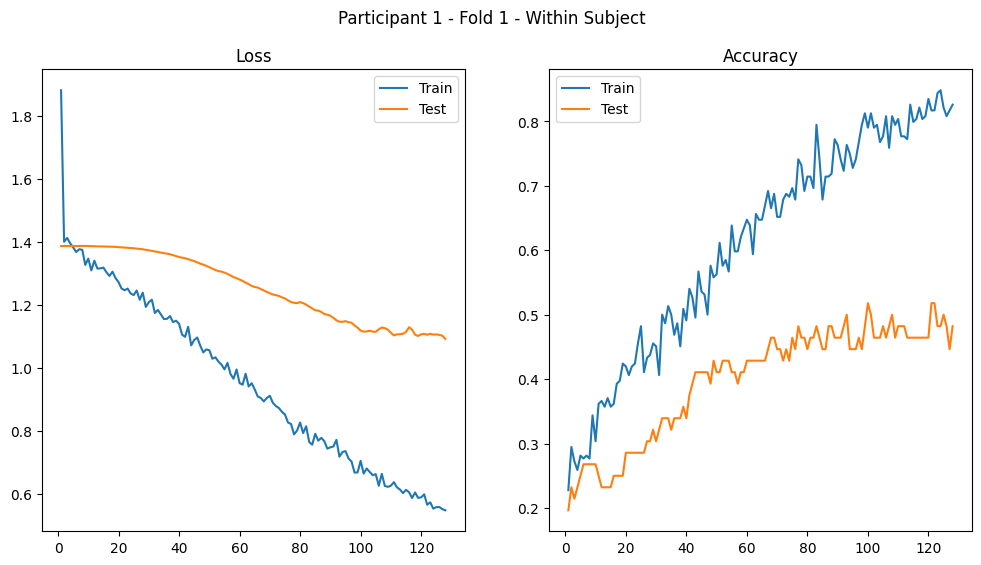

Outer Loop 2 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 220ms/step - loss: 2.4739 - accuracy: 0.2411 - val_loss: 1.4068 - val_accuracy: 0.2679
Epoch 2/500
4/4 [==============================] - 0s 72ms/step - loss: 1.6249 - accuracy: 0.2143 - val_loss: 1.4015 - val_accuracy: 0.2143
Epoch 3/500
4/4 [==============================] - 0s 70ms/step - loss: 1.5834 - accuracy: 0.2723 - val_loss: 1.3991 - val_accuracy: 0.1964
Epoch 4/500
4/4 [==============================] - 0s 68ms/step - loss: 1.5610 - accuracy: 0.2098 - val_loss: 1.3973 - val_accuracy: 0.1964
Ep

<Figure size 640x480 with 0 Axes>

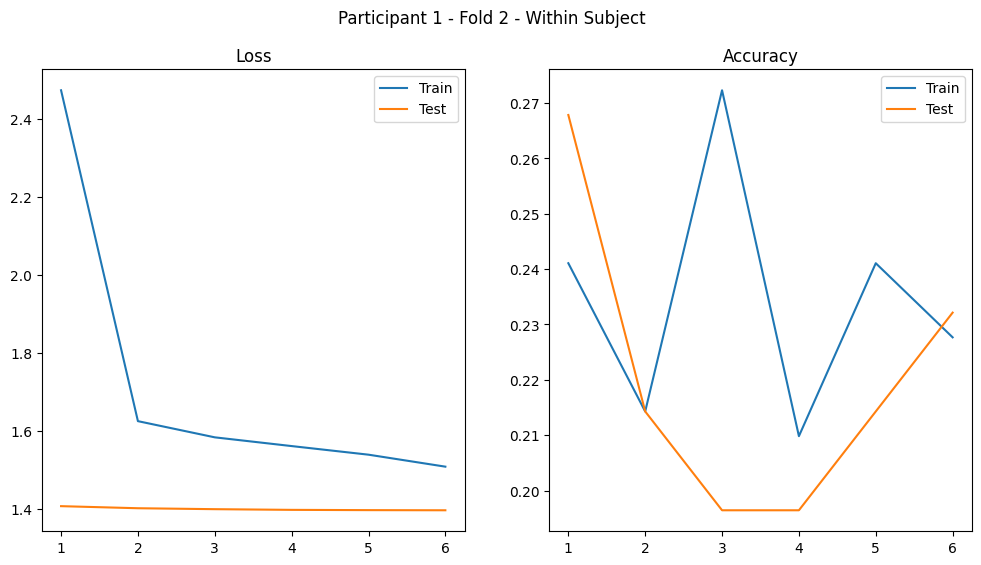

Outer Loop 3 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 202ms/step - loss: 1.9735 - accuracy: 0.2634 - val_loss: 1.4089 - val_accuracy: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 77ms/step - loss: 1.5029 - accuracy: 0.2500 - val_loss: 1.3993 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 71ms/step - loss: 1.5207 - accuracy: 0.2143 - val_loss: 1.3959 - val_accuracy: 0.2679
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4550 - accuracy: 0.2634 - val_loss: 1.3939 - val_accuracy: 0.2679
Ep

<Figure size 640x480 with 0 Axes>

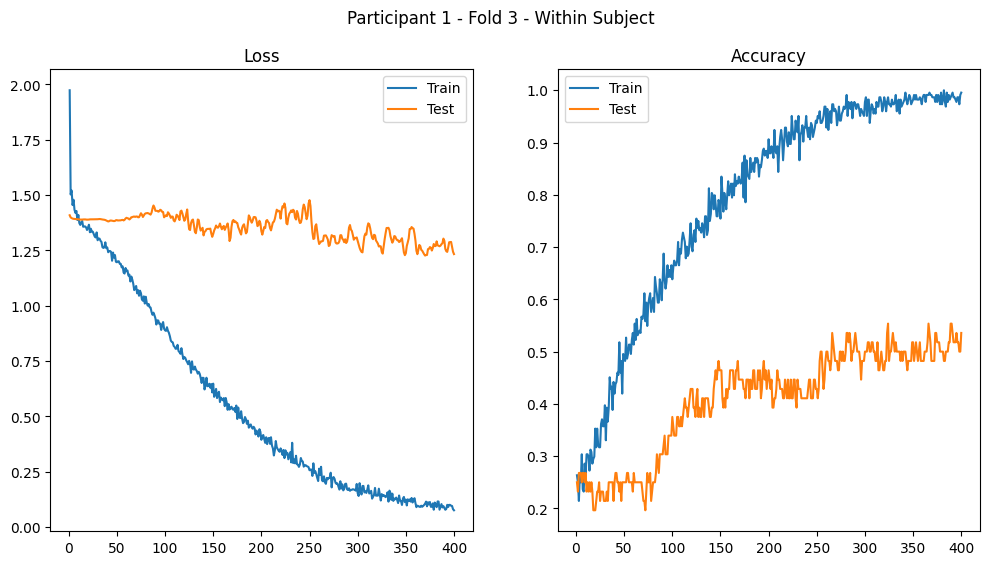

Outer Loop 4 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 219ms/step - loss: 1.6398 - accuracy: 0.2679 - val_loss: 1.4155 - val_accuracy: 0.2321
Epoch 2/500
4/4 [==============================] - 0s 73ms/step - loss: 1.4342 - accuracy: 0.2455 - val_loss: 1.4055 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 72ms/step - loss: 1.4250 - accuracy: 0.2857 - val_loss: 1.4015 - val_accuracy: 0.2143
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 1.3937 - accuracy: 0.2857 - val_loss: 1.3991 - val_accuracy: 0.2143
Ep

<Figure size 640x480 with 0 Axes>

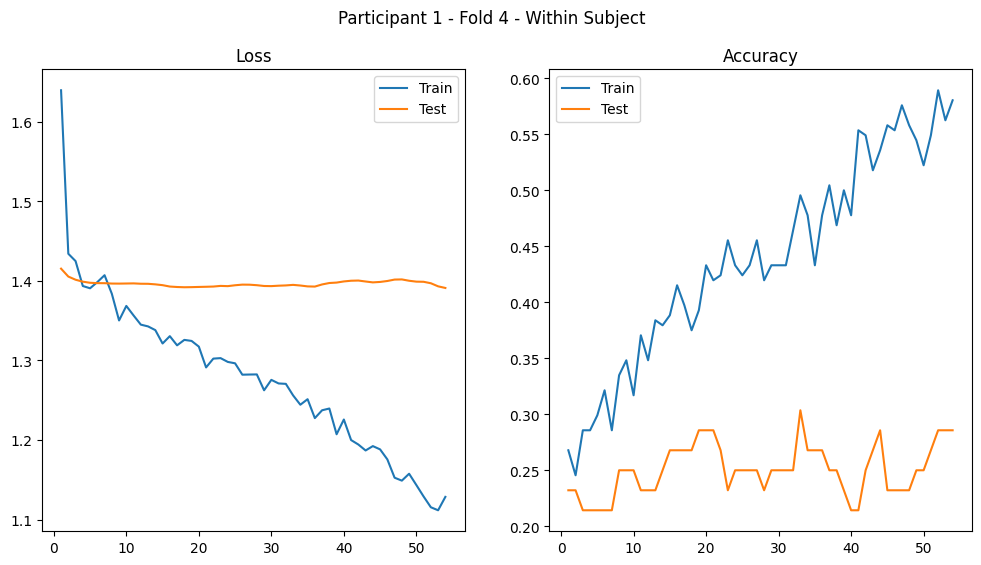

Outer Loop 5 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 213ms/step - loss: 2.1509 - accuracy: 0.2277 - val_loss: 1.4110 - val_accuracy: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 79ms/step - loss: 1.5039 - accuracy: 0.2545 - val_loss: 1.4022 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4968 - accuracy: 0.2723 - val_loss: 1.3986 - val_accuracy: 0.2321
Epoch 4/500
4/4 [==============================] - 0s 64ms/step - loss: 1.4813 - accuracy: 0.2500 - val_loss: 1.3963 - val_accuracy: 0.2500
Ep

<Figure size 640x480 with 0 Axes>

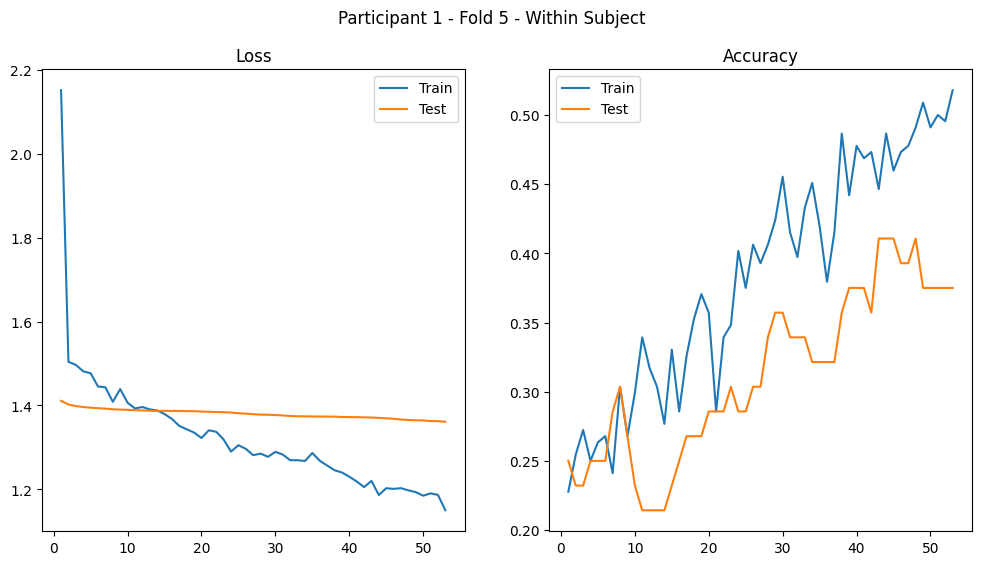

(278, 1)
Outer Loop 1 

      Train epochs' shape:                                (222, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (222, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (222, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 304ms/step - loss: 1.8412 - accuracy: 0.2297 - val_loss: 1.3789 - val_accuracy: 0.3214
Epoch 2/500
4/4 [==============================] - 0s 65ms/step - loss: 1.4846 - accuracy: 0.2252 - val_loss: 1.3799 - val_accuracy: 0.2857
Epoch 3/500
4/4 [==============================] - 0s 68ms/step - loss: 1.4464 - accuracy: 0.2387 - val_loss: 1.3803 - val_accuracy: 0.3214
Epoch 4/500
4/4 [==============================] - 0s 64ms/step - loss: 1.4532 - accuracy: 0.2117 - val_loss: 1.3807 - val_accuracy: 

<Figure size 640x480 with 0 Axes>

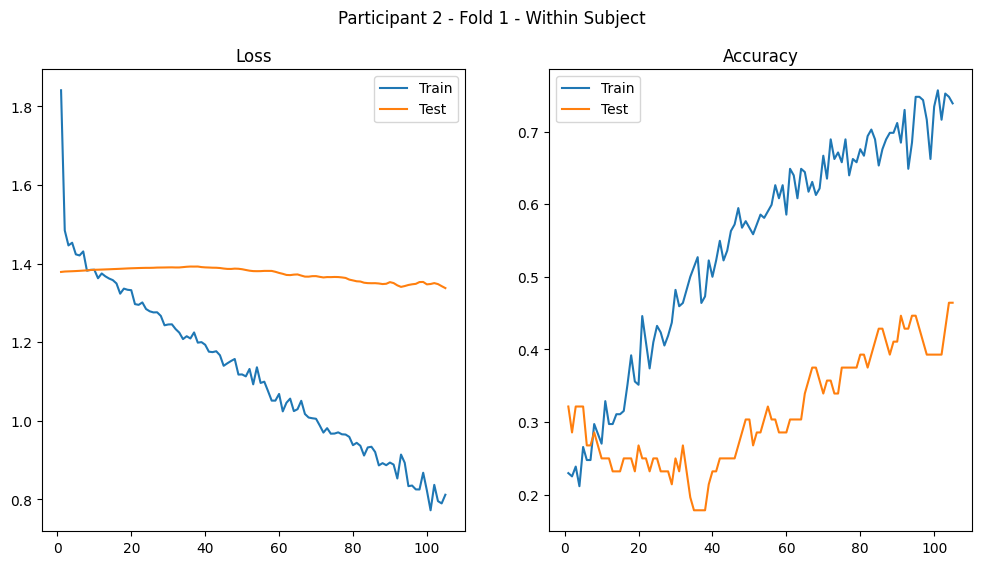

Outer Loop 2 

      Train epochs' shape:                                (222, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (222, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (222, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 227ms/step - loss: 2.0731 - accuracy: 0.2207 - val_loss: 1.3924 - val_accuracy: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 64ms/step - loss: 1.4671 - accuracy: 0.2523 - val_loss: 1.3898 - val_accuracy: 0.2857
Epoch 3/500
4/4 [==============================] - 0s 72ms/step - loss: 1.4953 - accuracy: 0.2162 - val_loss: 1.3884 - val_accuracy: 0.3036
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4555 - accuracy: 0.2207 - val_loss: 1.3866 - val_accuracy: 0.3036
Ep

<Figure size 640x480 with 0 Axes>

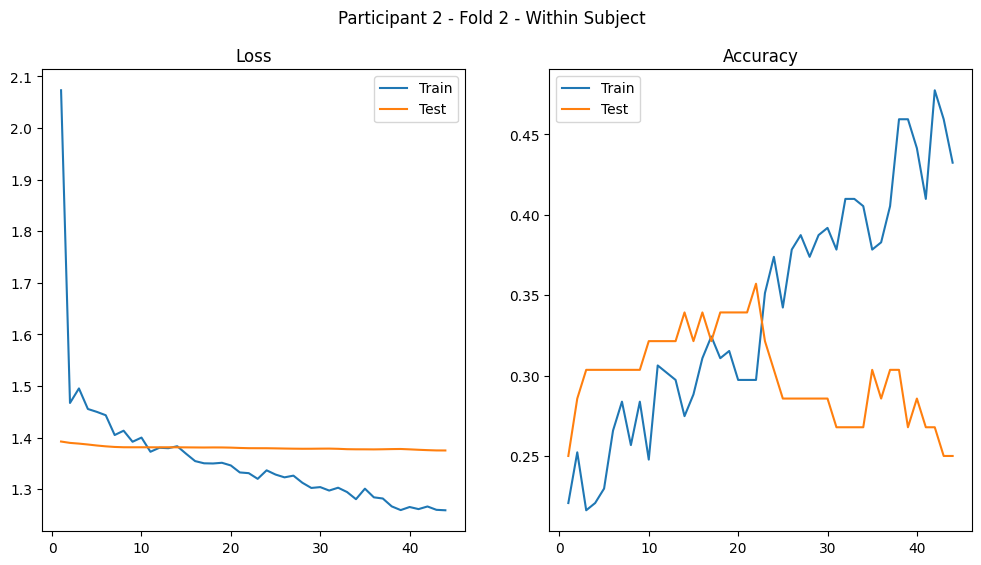

Outer Loop 3 

      Train epochs' shape:                                (222, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (222, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (222, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 214ms/step - loss: 1.8087 - accuracy: 0.2523 - val_loss: 1.3885 - val_accuracy: 0.2679
Epoch 2/500
4/4 [==============================] - 0s 68ms/step - loss: 1.4318 - accuracy: 0.2568 - val_loss: 1.3877 - val_accuracy: 0.2857
Epoch 3/500
4/4 [==============================] - 0s 72ms/step - loss: 1.4219 - accuracy: 0.2613 - val_loss: 1.3871 - val_accuracy: 0.2500
Epoch 4/500
4/4 [==============================] - 0s 69ms/step - loss: 1.4092 - accuracy: 0.2748 - val_loss: 1.3869 - val_accuracy: 0.2500
Ep

<Figure size 640x480 with 0 Axes>

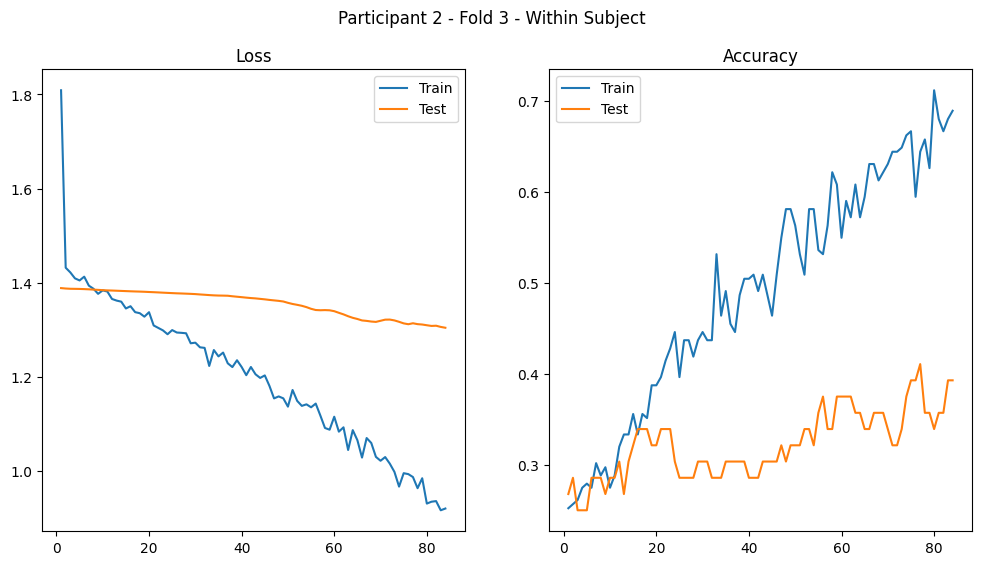

Outer Loop 4 

      Train epochs' shape:                                (223, 1, 64, 1123)
      Test epochs' shape:                                 (55, 1, 64, 1123)
      Train labels' shape:                                (223, 4)
      Test labels' shape:                                 (55, 4)
      Train labels' shape (without encoding):             (223, 1)
      Test labels' shape (without encoding):              (55, 1)



Epoch 1/500
4/4 [==============================] - 3s 351ms/step - loss: 2.5415 - accuracy: 0.2960 - val_loss: 1.4081 - val_accuracy: 0.2182
Epoch 2/500
4/4 [==============================] - 0s 72ms/step - loss: 1.6770 - accuracy: 0.2825 - val_loss: 1.3933 - val_accuracy: 0.2182
Epoch 3/500
4/4 [==============================] - 0s 68ms/step - loss: 1.5964 - accuracy: 0.2780 - val_loss: 1.3878 - val_accuracy: 0.2182
Epoch 4/500
4/4 [==============================] - 0s 71ms/step - loss: 1.5875 - accuracy: 0.2735 - val_loss: 1.3853 - val_accuracy: 0.2364
Ep

<Figure size 640x480 with 0 Axes>

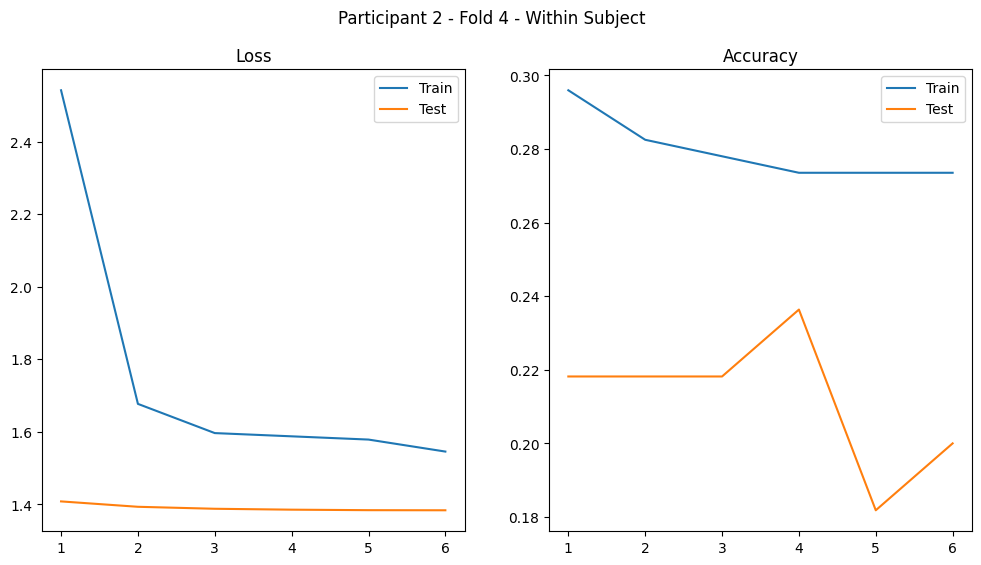

Outer Loop 5 

      Train epochs' shape:                                (223, 1, 64, 1123)
      Test epochs' shape:                                 (55, 1, 64, 1123)
      Train labels' shape:                                (223, 4)
      Test labels' shape:                                 (55, 4)
      Train labels' shape (without encoding):             (223, 1)
      Test labels' shape (without encoding):              (55, 1)



Epoch 1/500
4/4 [==============================] - 3s 196ms/step - loss: 1.9601 - accuracy: 0.2646 - val_loss: 1.3939 - val_accuracy: 0.2364
Epoch 2/500
4/4 [==============================] - 0s 68ms/step - loss: 1.4969 - accuracy: 0.2780 - val_loss: 1.3880 - val_accuracy: 0.2545
Epoch 3/500
4/4 [==============================] - 0s 63ms/step - loss: 1.4629 - accuracy: 0.2556 - val_loss: 1.3853 - val_accuracy: 0.2727
Epoch 4/500
4/4 [==============================] - 0s 68ms/step - loss: 1.4413 - accuracy: 0.3094 - val_loss: 1.3838 - val_accuracy: 0.2727
Ep

<Figure size 640x480 with 0 Axes>

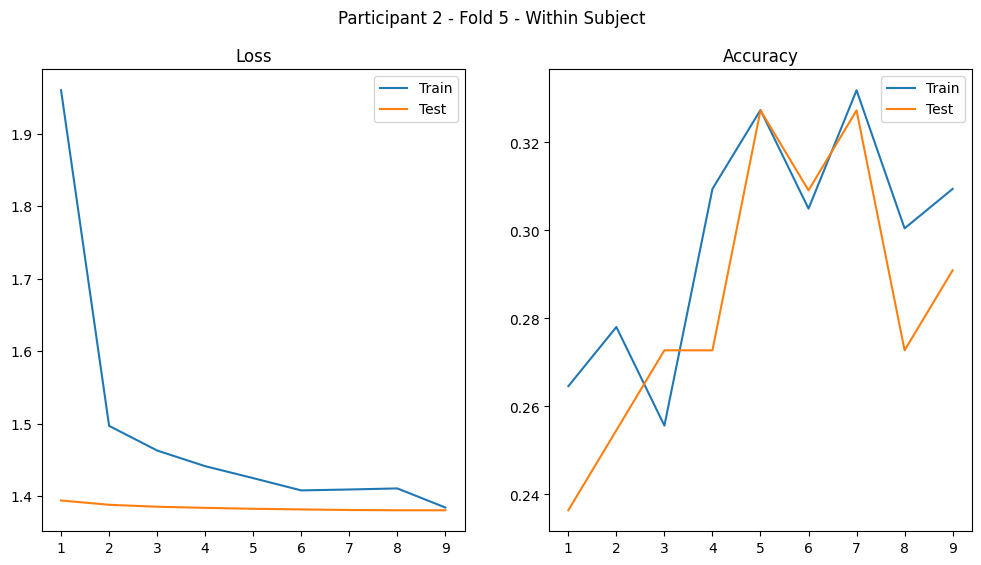

(280, 1)
Outer Loop 1 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 224ms/step - loss: 2.4061 - accuracy: 0.2277 - val_loss: 1.4050 - val_accuracy: 0.2321
Epoch 2/500
4/4 [==============================] - 0s 76ms/step - loss: 1.5560 - accuracy: 0.2098 - val_loss: 1.3987 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 71ms/step - loss: 1.5428 - accuracy: 0.2411 - val_loss: 1.3961 - val_accuracy: 0.2679
Epoch 4/500
4/4 [==============================] - 0s 71ms/step - loss: 1.5078 - accuracy: 0.2188 - val_loss: 1.3943 - val_accuracy: 

<Figure size 640x480 with 0 Axes>

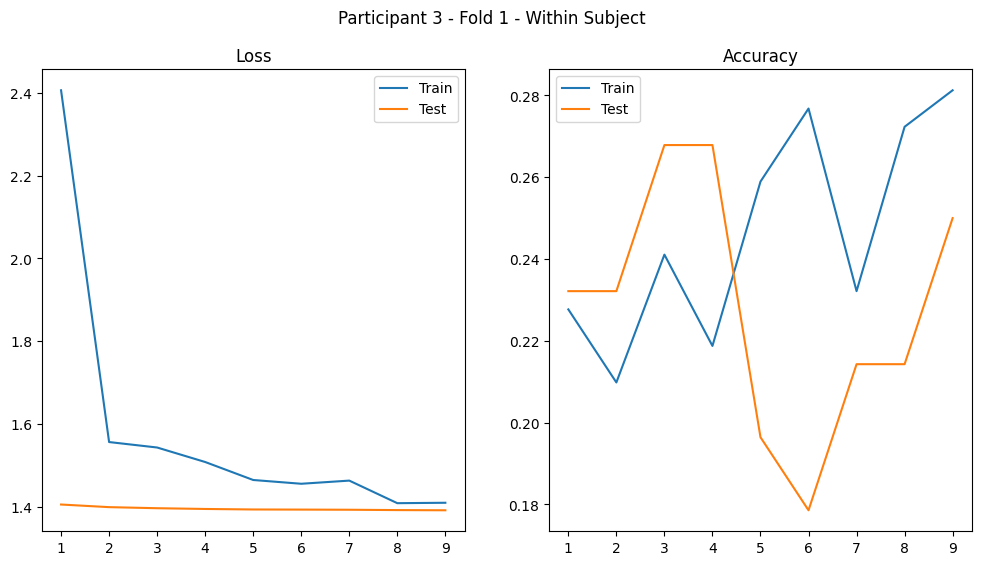

Outer Loop 2 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 203ms/step - loss: 1.9331 - accuracy: 0.2455 - val_loss: 1.4125 - val_accuracy: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 73ms/step - loss: 1.5142 - accuracy: 0.2545 - val_loss: 1.4054 - val_accuracy: 0.2679
Epoch 3/500
4/4 [==============================] - 0s 74ms/step - loss: 1.5212 - accuracy: 0.2768 - val_loss: 1.4021 - val_accuracy: 0.2679
Epoch 4/500
4/4 [==============================] - 0s 73ms/step - loss: 1.4693 - accuracy: 0.2679 - val_loss: 1.3997 - val_accuracy: 0.2679
Ep

<Figure size 640x480 with 0 Axes>

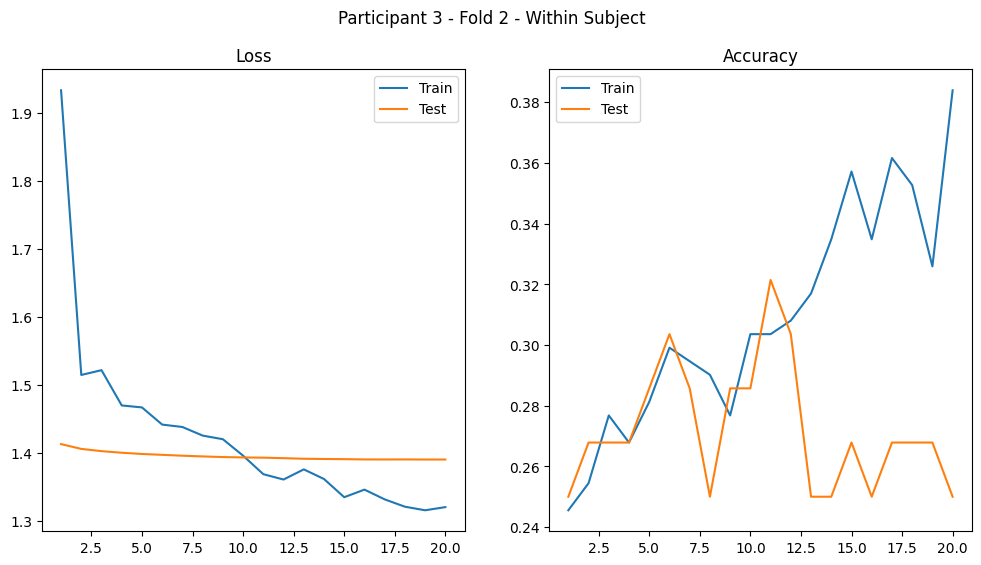

Outer Loop 3 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 211ms/step - loss: 2.4002 - accuracy: 0.2634 - val_loss: 1.3852 - val_accuracy: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 76ms/step - loss: 1.5473 - accuracy: 0.2946 - val_loss: 1.3841 - val_accuracy: 0.2500
Epoch 3/500
4/4 [==============================] - 0s 70ms/step - loss: 1.5166 - accuracy: 0.2857 - val_loss: 1.3834 - val_accuracy: 0.2500
Epoch 4/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4916 - accuracy: 0.2679 - val_loss: 1.3827 - val_accuracy: 0.2500
Ep

<Figure size 640x480 with 0 Axes>

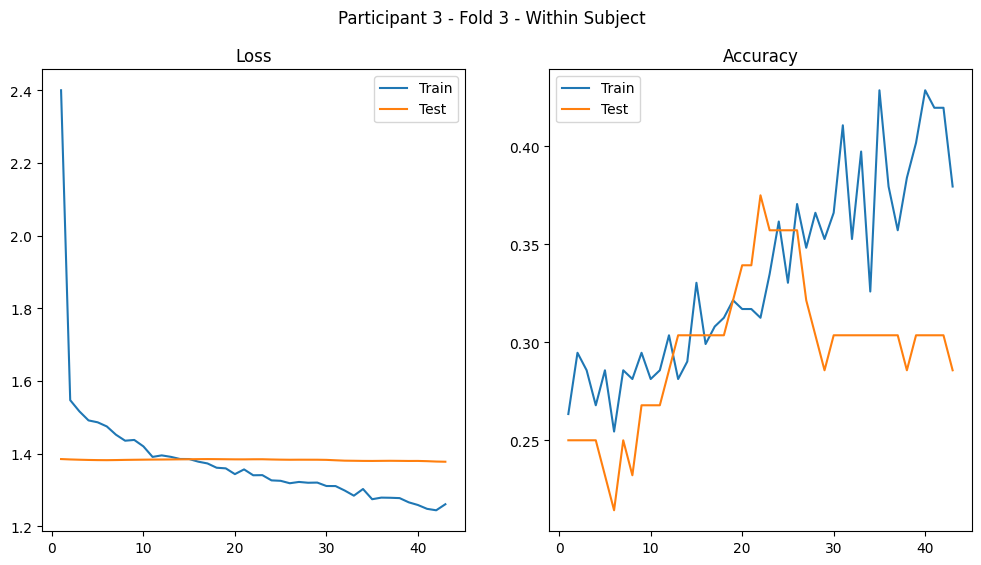

Outer Loop 4 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 210ms/step - loss: 1.7849 - accuracy: 0.2545 - val_loss: 1.3913 - val_accuracy: 0.2857
Epoch 2/500
4/4 [==============================] - 0s 68ms/step - loss: 1.4393 - accuracy: 0.2321 - val_loss: 1.3881 - val_accuracy: 0.3036
Epoch 3/500
4/4 [==============================] - 0s 73ms/step - loss: 1.4470 - accuracy: 0.2232 - val_loss: 1.3867 - val_accuracy: 0.2857
Epoch 4/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4221 - accuracy: 0.2500 - val_loss: 1.3862 - val_accuracy: 0.2679
Ep

<Figure size 640x480 with 0 Axes>

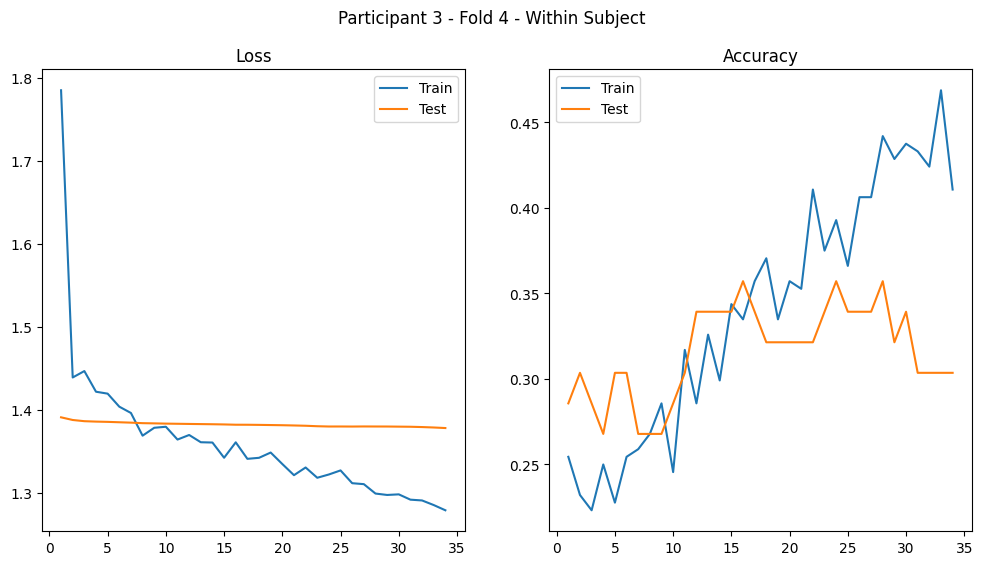

Outer Loop 5 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 209ms/step - loss: 1.7023 - accuracy: 0.2812 - val_loss: 1.3980 - val_accuracy: 0.1964
Epoch 2/500
4/4 [==============================] - 0s 76ms/step - loss: 1.4507 - accuracy: 0.2098 - val_loss: 1.3952 - val_accuracy: 0.1964
Epoch 3/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4107 - accuracy: 0.2500 - val_loss: 1.3935 - val_accuracy: 0.1607
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4274 - accuracy: 0.2321 - val_loss: 1.3920 - val_accuracy: 0.1786
Ep

<Figure size 640x480 with 0 Axes>

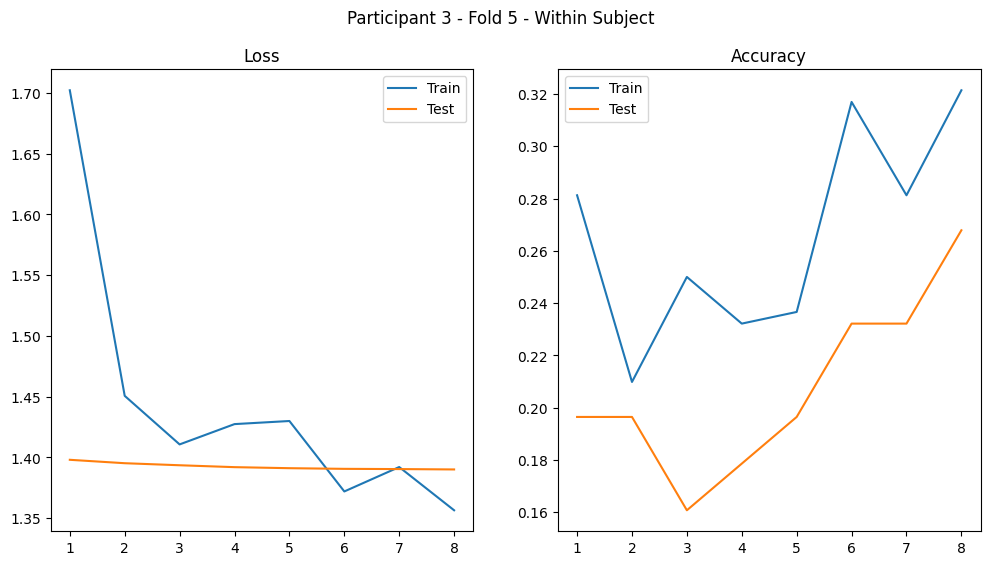

(279, 1)
Outer Loop 1 

      Train epochs' shape:                                (223, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (223, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (223, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 205ms/step - loss: 1.7863 - accuracy: 0.2466 - val_loss: 1.3787 - val_accuracy: 0.3036
Epoch 2/500
4/4 [==============================] - 0s 73ms/step - loss: 1.4350 - accuracy: 0.2511 - val_loss: 1.3768 - val_accuracy: 0.3214
Epoch 3/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4022 - accuracy: 0.2646 - val_loss: 1.3765 - val_accuracy: 0.3750
Epoch 4/500
4/4 [==============================] - 0s 68ms/step - loss: 1.3980 - accuracy: 0.2915 - val_loss: 1.3770 - val_accuracy: 

<Figure size 640x480 with 0 Axes>

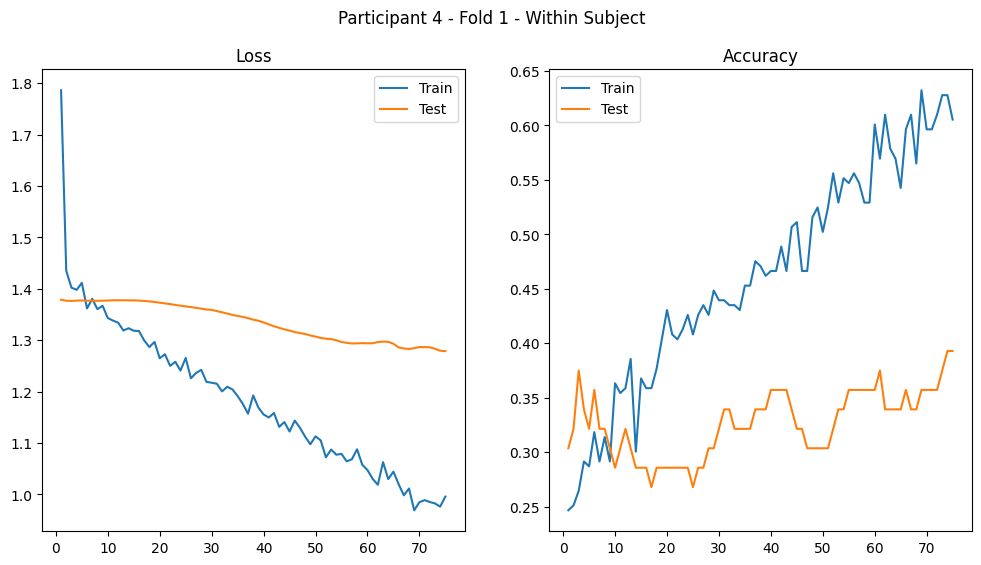

Outer Loop 2 

      Train epochs' shape:                                (223, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (223, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (223, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 212ms/step - loss: 2.5912 - accuracy: 0.2556 - val_loss: 1.4102 - val_accuracy: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 75ms/step - loss: 1.5887 - accuracy: 0.2556 - val_loss: 1.3948 - val_accuracy: 0.2500
Epoch 3/500
4/4 [==============================] - 0s 68ms/step - loss: 1.5311 - accuracy: 0.2511 - val_loss: 1.3870 - val_accuracy: 0.2500
Epoch 4/500
4/4 [==============================] - 0s 72ms/step - loss: 1.4970 - accuracy: 0.2601 - val_loss: 1.3823 - val_accuracy: 0.2679
Ep

<Figure size 640x480 with 0 Axes>

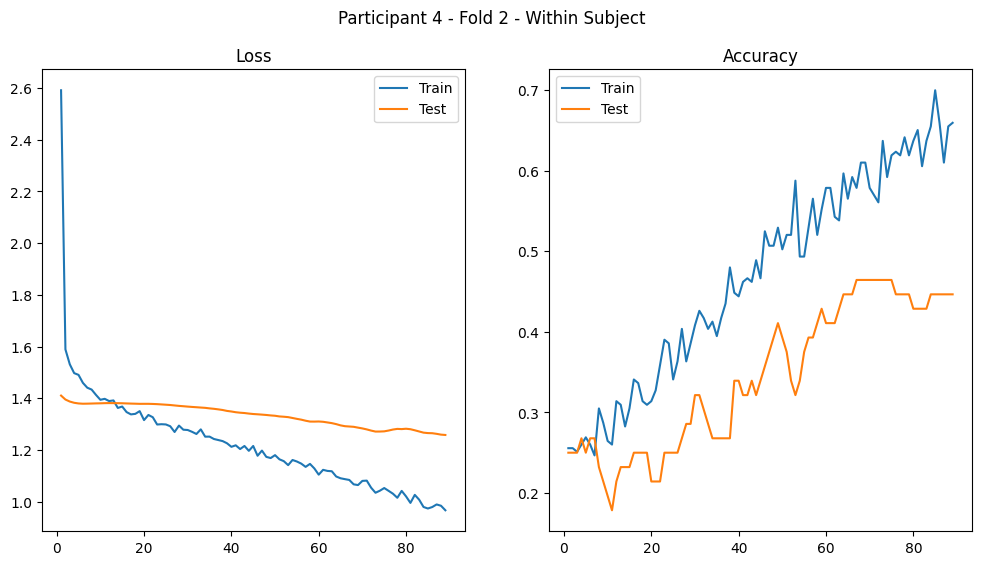

Outer Loop 3 

      Train epochs' shape:                                (223, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (223, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (223, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 195ms/step - loss: 2.0308 - accuracy: 0.2556 - val_loss: 1.3898 - val_accuracy: 0.2679
Epoch 2/500
4/4 [==============================] - 0s 75ms/step - loss: 1.5005 - accuracy: 0.2691 - val_loss: 1.3855 - val_accuracy: 0.2500
Epoch 3/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4331 - accuracy: 0.2780 - val_loss: 1.3842 - val_accuracy: 0.2679
Epoch 4/500
4/4 [==============================] - 0s 66ms/step - loss: 1.4645 - accuracy: 0.2735 - val_loss: 1.3843 - val_accuracy: 0.2857
Ep

<Figure size 640x480 with 0 Axes>

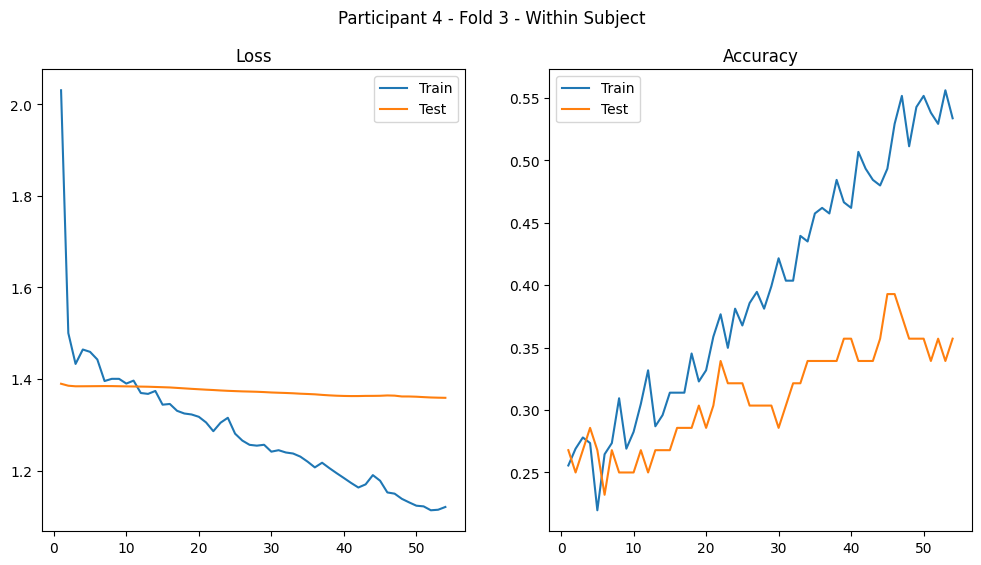

Outer Loop 4 

      Train epochs' shape:                                (223, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (223, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (223, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 213ms/step - loss: 1.7782 - accuracy: 0.2422 - val_loss: 1.3876 - val_accuracy: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 73ms/step - loss: 1.4702 - accuracy: 0.2332 - val_loss: 1.3856 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 67ms/step - loss: 1.4513 - accuracy: 0.3184 - val_loss: 1.3840 - val_accuracy: 0.2500
Epoch 4/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4377 - accuracy: 0.2915 - val_loss: 1.3827 - val_accuracy: 0.2500
Ep

<Figure size 640x480 with 0 Axes>

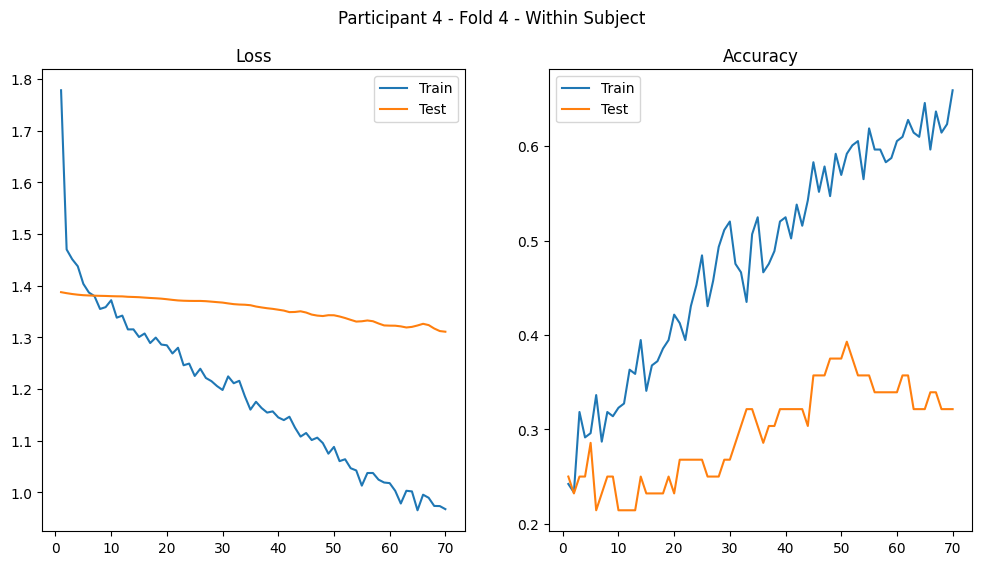

Outer Loop 5 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (55, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (55, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (55, 1)



Epoch 1/500
4/4 [==============================] - 3s 223ms/step - loss: 2.0663 - accuracy: 0.2098 - val_loss: 1.4099 - val_accuracy: 0.1818
Epoch 2/500
4/4 [==============================] - 0s 74ms/step - loss: 1.5140 - accuracy: 0.1964 - val_loss: 1.4024 - val_accuracy: 0.1636
Epoch 3/500
4/4 [==============================] - 0s 66ms/step - loss: 1.4839 - accuracy: 0.2054 - val_loss: 1.3976 - val_accuracy: 0.1455
Epoch 4/500
4/4 [==============================] - 0s 68ms/step - loss: 1.4408 - accuracy: 0.2321 - val_loss: 1.3955 - val_accuracy: 0.1818
Ep

<Figure size 640x480 with 0 Axes>

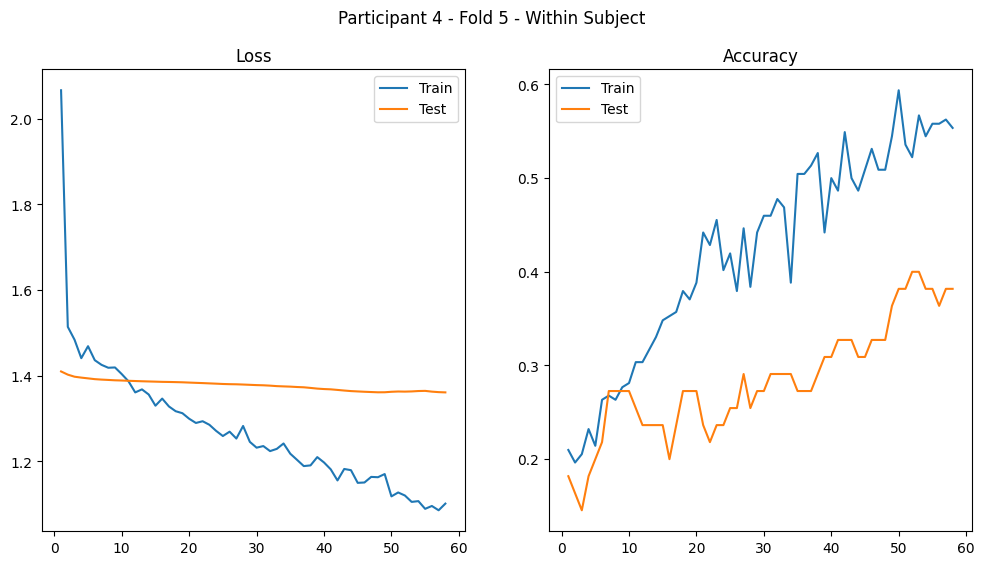

(279, 1)
Outer Loop 1 

      Train epochs' shape:                                (223, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (223, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (223, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 220ms/step - loss: 1.9992 - accuracy: 0.2466 - val_loss: 1.5775 - val_accuracy: 0.2321
Epoch 2/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4926 - accuracy: 0.2332 - val_loss: 1.5125 - val_accuracy: 0.1964
Epoch 3/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4774 - accuracy: 0.2422 - val_loss: 1.4798 - val_accuracy: 0.1964
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4540 - accuracy: 0.2601 - val_loss: 1.4576 - val_accuracy: 

<Figure size 640x480 with 0 Axes>

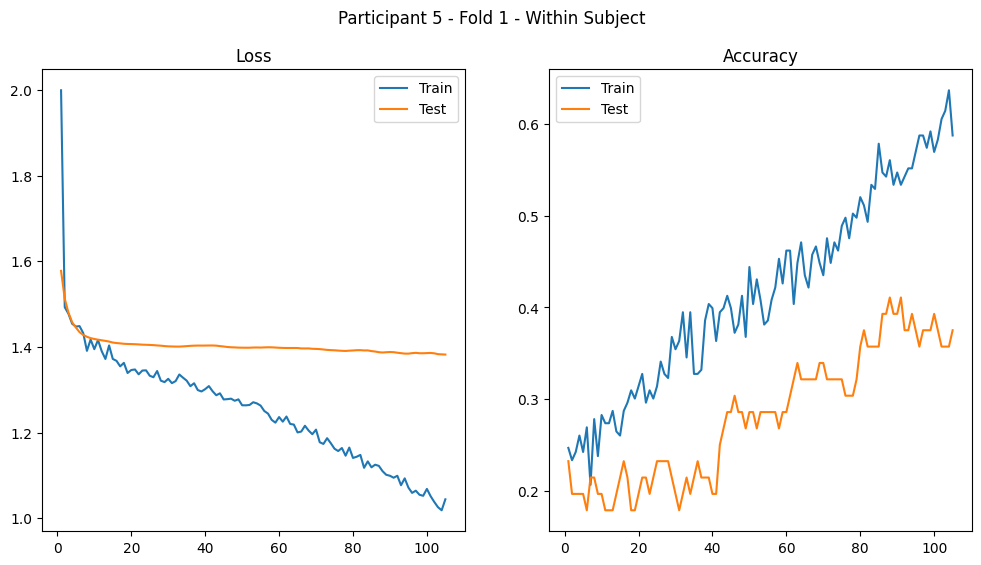

Outer Loop 2 

      Train epochs' shape:                                (223, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (223, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (223, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 202ms/step - loss: 1.9831 - accuracy: 0.2691 - val_loss: 1.4002 - val_accuracy: 0.1786
Epoch 2/500
4/4 [==============================] - 0s 74ms/step - loss: 1.5073 - accuracy: 0.2287 - val_loss: 1.3991 - val_accuracy: 0.2143
Epoch 3/500
4/4 [==============================] - 0s 72ms/step - loss: 1.4639 - accuracy: 0.2735 - val_loss: 1.3962 - val_accuracy: 0.1964
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4710 - accuracy: 0.2422 - val_loss: 1.3935 - val_accuracy: 0.1786
Ep

<Figure size 640x480 with 0 Axes>

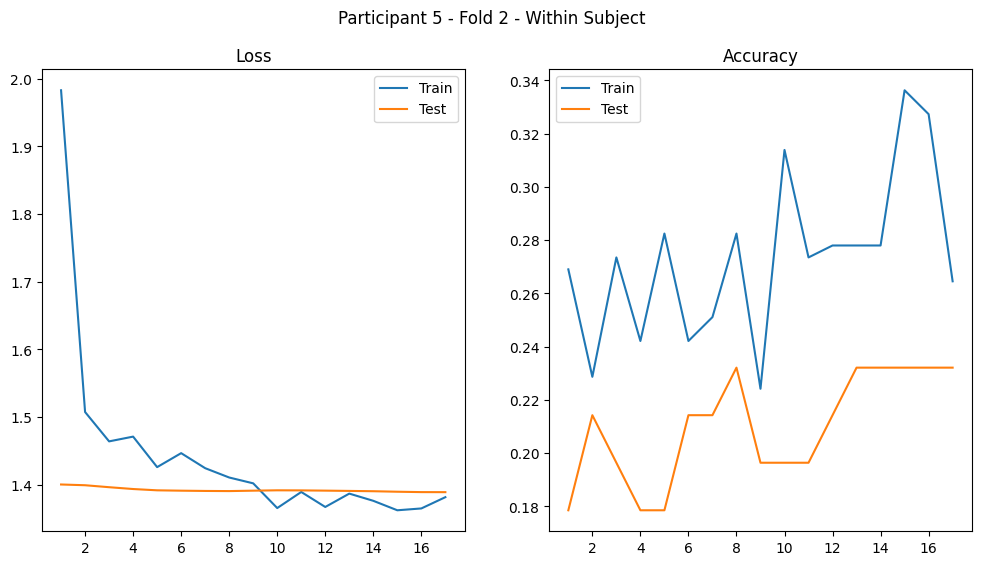

Outer Loop 3 

      Train epochs' shape:                                (223, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (223, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (223, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 206ms/step - loss: 1.9036 - accuracy: 0.2332 - val_loss: 1.4060 - val_accuracy: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 75ms/step - loss: 1.5369 - accuracy: 0.2466 - val_loss: 1.3913 - val_accuracy: 0.2500
Epoch 3/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4924 - accuracy: 0.2242 - val_loss: 1.3848 - val_accuracy: 0.2679
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4524 - accuracy: 0.2511 - val_loss: 1.3812 - val_accuracy: 0.2857
Ep

<Figure size 640x480 with 0 Axes>

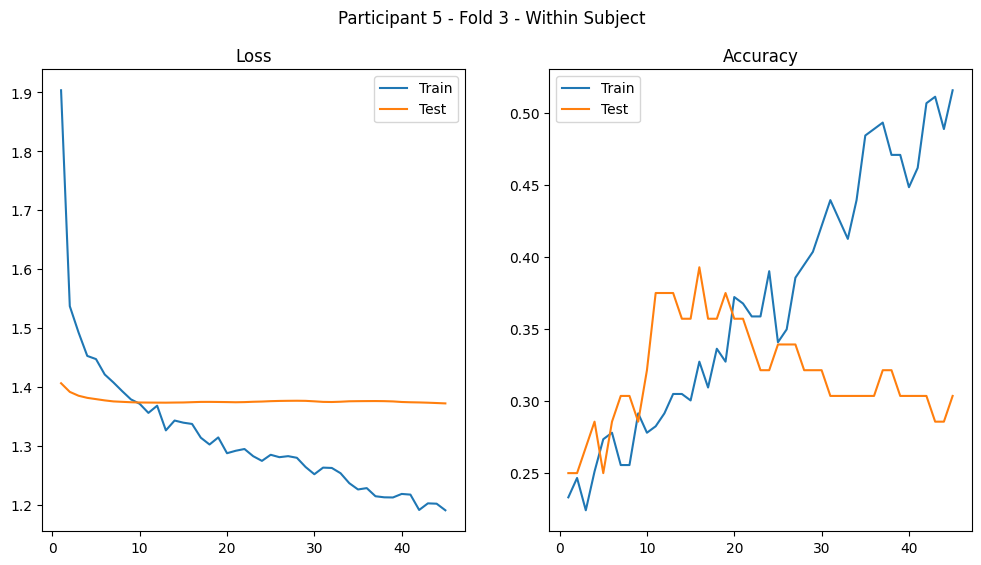

Outer Loop 4 

      Train epochs' shape:                                (223, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (223, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (223, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 214ms/step - loss: 2.2802 - accuracy: 0.2601 - val_loss: 1.4199 - val_accuracy: 0.2857
Epoch 2/500
4/4 [==============================] - 0s 70ms/step - loss: 1.6530 - accuracy: 0.2197 - val_loss: 1.4084 - val_accuracy: 0.2857
Epoch 3/500
4/4 [==============================] - 0s 72ms/step - loss: 1.5582 - accuracy: 0.2377 - val_loss: 1.4012 - val_accuracy: 0.2857
Epoch 4/500
4/4 [==============================] - 0s 71ms/step - loss: 1.5598 - accuracy: 0.2466 - val_loss: 1.3968 - val_accuracy: 0.2857
Ep

<Figure size 640x480 with 0 Axes>

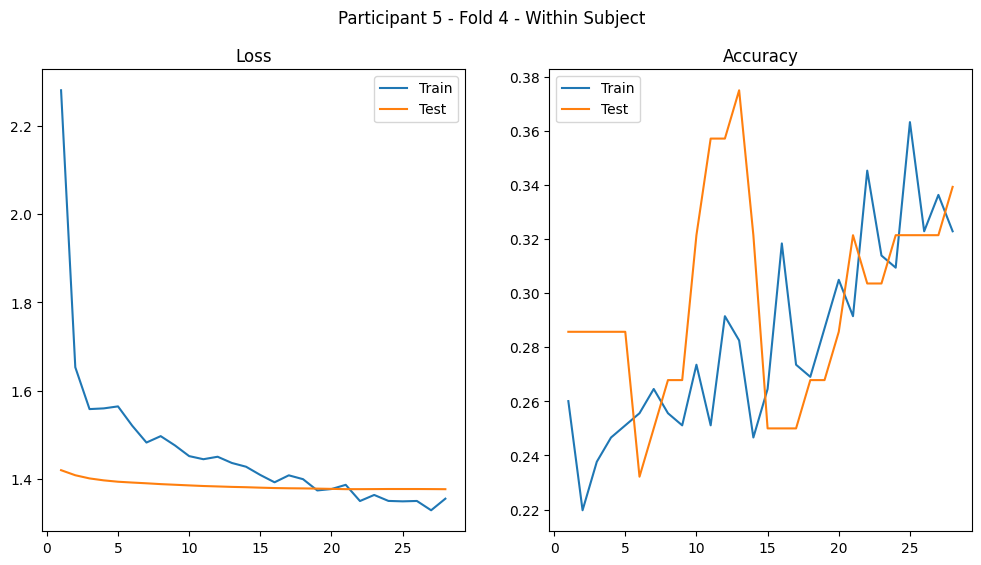

Outer Loop 5 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (55, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (55, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (55, 1)



Epoch 1/500
4/4 [==============================] - 3s 211ms/step - loss: 1.9109 - accuracy: 0.2455 - val_loss: 1.3938 - val_accuracy: 0.2545
Epoch 2/500
4/4 [==============================] - 0s 73ms/step - loss: 1.4870 - accuracy: 0.2366 - val_loss: 1.3919 - val_accuracy: 0.2364
Epoch 3/500
4/4 [==============================] - 0s 66ms/step - loss: 1.4959 - accuracy: 0.2857 - val_loss: 1.3911 - val_accuracy: 0.2545
Epoch 4/500
4/4 [==============================] - 0s 72ms/step - loss: 1.4929 - accuracy: 0.2545 - val_loss: 1.3904 - val_accuracy: 0.2909
Ep

<Figure size 640x480 with 0 Axes>

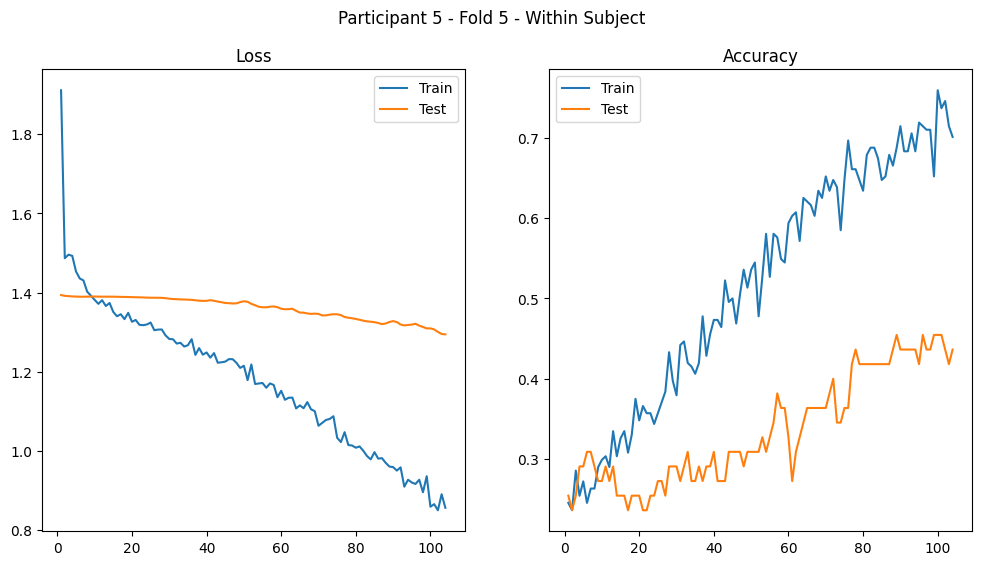

(280, 1)
Outer Loop 1 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 214ms/step - loss: 2.7059 - accuracy: 0.2902 - val_loss: 1.4245 - val_accuracy: 0.2321
Epoch 2/500
4/4 [==============================] - 0s 75ms/step - loss: 1.5917 - accuracy: 0.2366 - val_loss: 1.4136 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 68ms/step - loss: 1.5593 - accuracy: 0.2589 - val_loss: 1.4085 - val_accuracy: 0.2321
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 1.5169 - accuracy: 0.2545 - val_loss: 1.4054 - val_accuracy: 

<Figure size 640x480 with 0 Axes>

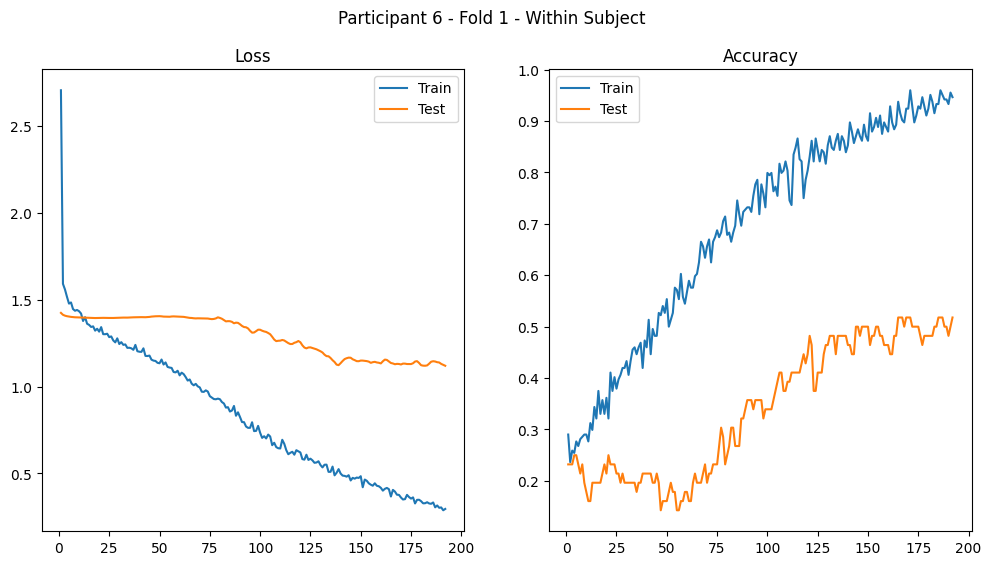

Outer Loop 2 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 200ms/step - loss: 2.4233 - accuracy: 0.2366 - val_loss: 1.3993 - val_accuracy: 0.2679
Epoch 2/500
4/4 [==============================] - 0s 73ms/step - loss: 1.5315 - accuracy: 0.2455 - val_loss: 1.3951 - val_accuracy: 0.2857
Epoch 3/500
4/4 [==============================] - 0s 67ms/step - loss: 1.5258 - accuracy: 0.2634 - val_loss: 1.3926 - val_accuracy: 0.2679
Epoch 4/500
4/4 [==============================] - 0s 67ms/step - loss: 1.4503 - accuracy: 0.2589 - val_loss: 1.3905 - val_accuracy: 0.2500
Ep

<Figure size 640x480 with 0 Axes>

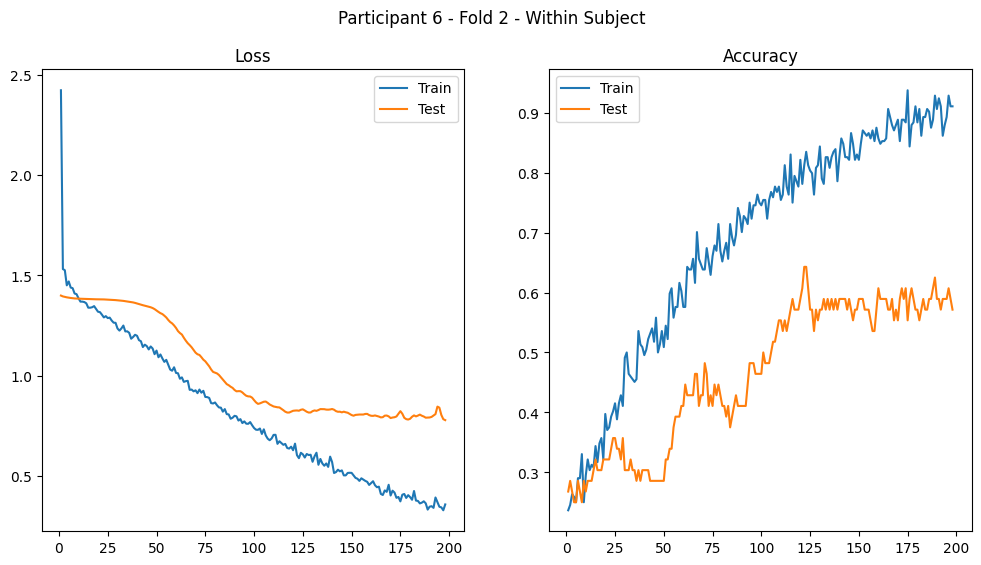

Outer Loop 3 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 216ms/step - loss: 2.7914 - accuracy: 0.2545 - val_loss: 1.3888 - val_accuracy: 0.2679
Epoch 2/500
4/4 [==============================] - 0s 72ms/step - loss: 1.6035 - accuracy: 0.2634 - val_loss: 1.3863 - val_accuracy: 0.3036
Epoch 3/500
4/4 [==============================] - 0s 72ms/step - loss: 1.5901 - accuracy: 0.2679 - val_loss: 1.3849 - val_accuracy: 0.3214
Epoch 4/500
4/4 [==============================] - 0s 73ms/step - loss: 1.5227 - accuracy: 0.2589 - val_loss: 1.3843 - val_accuracy: 0.3214
Ep

<Figure size 640x480 with 0 Axes>

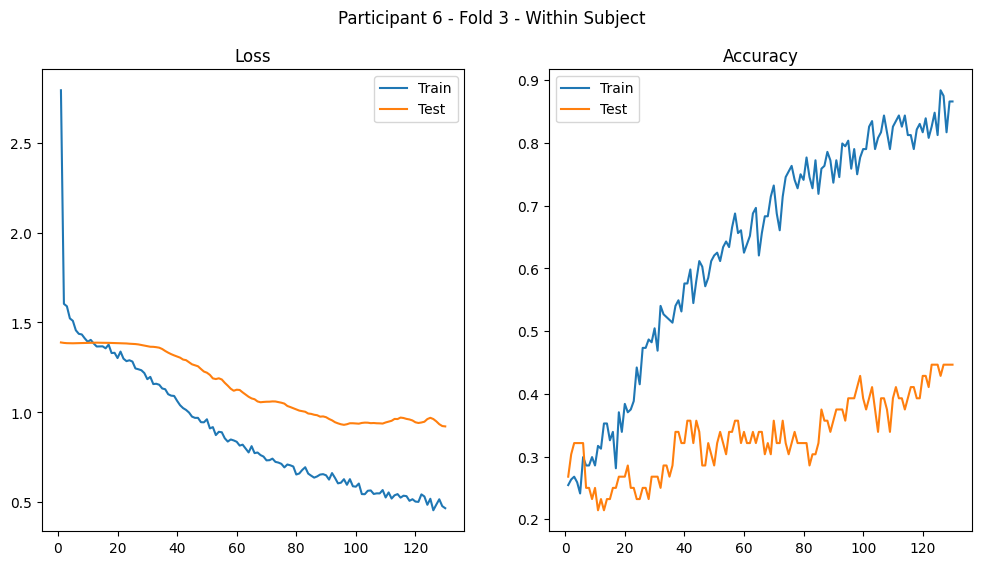

Outer Loop 4 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 210ms/step - loss: 2.5032 - accuracy: 0.2411 - val_loss: 1.4458 - val_accuracy: 0.2679
Epoch 2/500
4/4 [==============================] - 0s 70ms/step - loss: 1.5680 - accuracy: 0.2634 - val_loss: 1.4233 - val_accuracy: 0.2679
Epoch 3/500
4/4 [==============================] - 0s 71ms/step - loss: 1.5550 - accuracy: 0.2634 - val_loss: 1.4136 - val_accuracy: 0.2679
Epoch 4/500
4/4 [==============================] - 0s 72ms/step - loss: 1.4910 - accuracy: 0.2500 - val_loss: 1.4081 - val_accuracy: 0.2857
Ep

<Figure size 640x480 with 0 Axes>

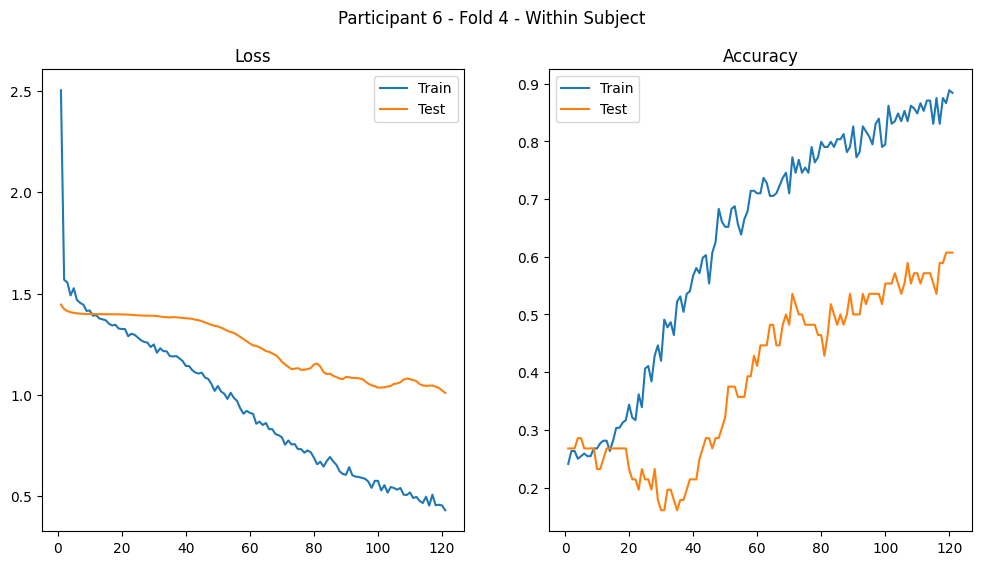

Outer Loop 5 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 208ms/step - loss: 2.2238 - accuracy: 0.2500 - val_loss: 1.3958 - val_accuracy: 0.2857
Epoch 2/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4791 - accuracy: 0.2723 - val_loss: 1.3916 - val_accuracy: 0.3036
Epoch 3/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4269 - accuracy: 0.3170 - val_loss: 1.3898 - val_accuracy: 0.3036
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4401 - accuracy: 0.2679 - val_loss: 1.3887 - val_accuracy: 0.2679
Ep

<Figure size 640x480 with 0 Axes>

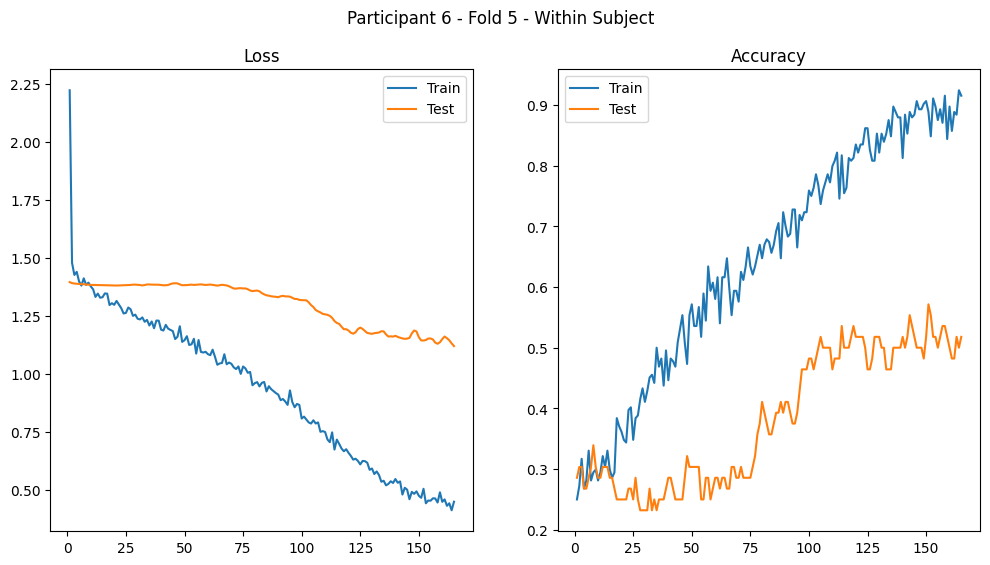

(280, 1)
Outer Loop 1 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 229ms/step - loss: 2.7401 - accuracy: 0.2455 - val_loss: 1.4264 - val_accuracy: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 72ms/step - loss: 1.6603 - accuracy: 0.2455 - val_loss: 1.4086 - val_accuracy: 0.2679
Epoch 3/500
4/4 [==============================] - 0s 70ms/step - loss: 1.6194 - accuracy: 0.2500 - val_loss: 1.3997 - val_accuracy: 0.2857
Epoch 4/500
4/4 [==============================] - 0s 71ms/step - loss: 1.5759 - accuracy: 0.2455 - val_loss: 1.3959 - val_accuracy: 

<Figure size 640x480 with 0 Axes>

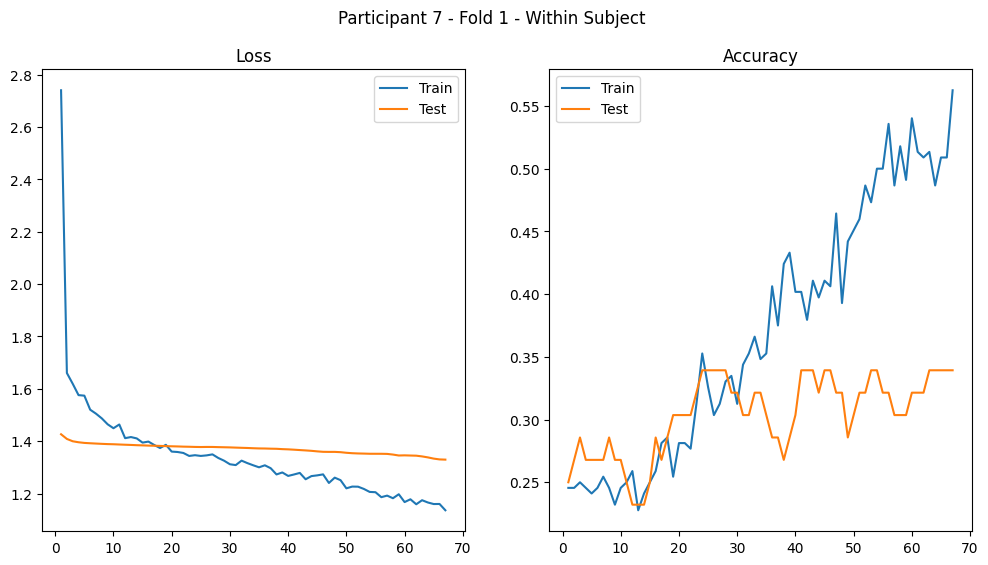

Outer Loop 2 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 224ms/step - loss: 2.0477 - accuracy: 0.2723 - val_loss: 1.4090 - val_accuracy: 0.2857
Epoch 2/500
4/4 [==============================] - 0s 68ms/step - loss: 1.5057 - accuracy: 0.2812 - val_loss: 1.4022 - val_accuracy: 0.2679
Epoch 3/500
4/4 [==============================] - 0s 66ms/step - loss: 1.4512 - accuracy: 0.2857 - val_loss: 1.3998 - val_accuracy: 0.2857
Epoch 4/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4591 - accuracy: 0.2768 - val_loss: 1.3981 - val_accuracy: 0.2857
Ep

<Figure size 640x480 with 0 Axes>

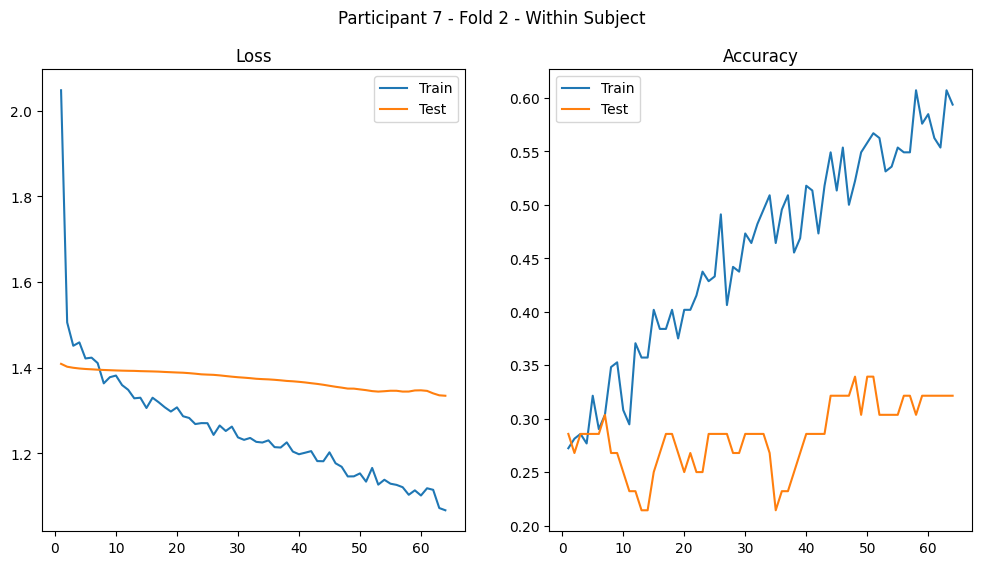

Outer Loop 3 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 201ms/step - loss: 1.6498 - accuracy: 0.2589 - val_loss: 1.3855 - val_accuracy: 0.2679
Epoch 2/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4287 - accuracy: 0.2411 - val_loss: 1.3845 - val_accuracy: 0.2857
Epoch 3/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4033 - accuracy: 0.2991 - val_loss: 1.3837 - val_accuracy: 0.2857
Epoch 4/500
4/4 [==============================] - 0s 72ms/step - loss: 1.4025 - accuracy: 0.3438 - val_loss: 1.3831 - val_accuracy: 0.2679
Ep

<Figure size 640x480 with 0 Axes>

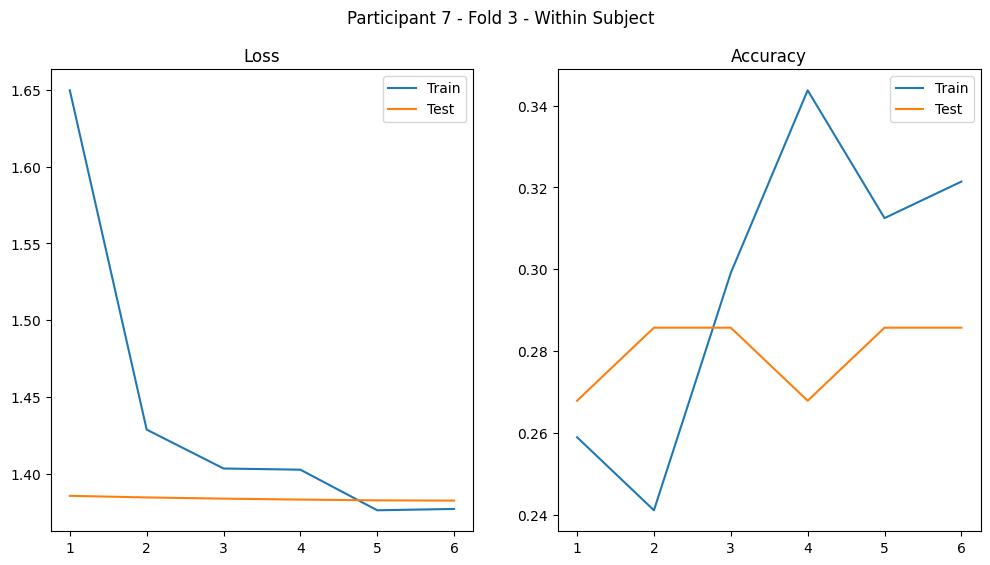

Outer Loop 4 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 214ms/step - loss: 1.7291 - accuracy: 0.2188 - val_loss: 1.3887 - val_accuracy: 0.2321
Epoch 2/500
4/4 [==============================] - 0s 69ms/step - loss: 1.4106 - accuracy: 0.2366 - val_loss: 1.3865 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4451 - accuracy: 0.2232 - val_loss: 1.3851 - val_accuracy: 0.2143
Epoch 4/500
4/4 [==============================] - 0s 66ms/step - loss: 1.4060 - accuracy: 0.2589 - val_loss: 1.3841 - val_accuracy: 0.2143
Ep

<Figure size 640x480 with 0 Axes>

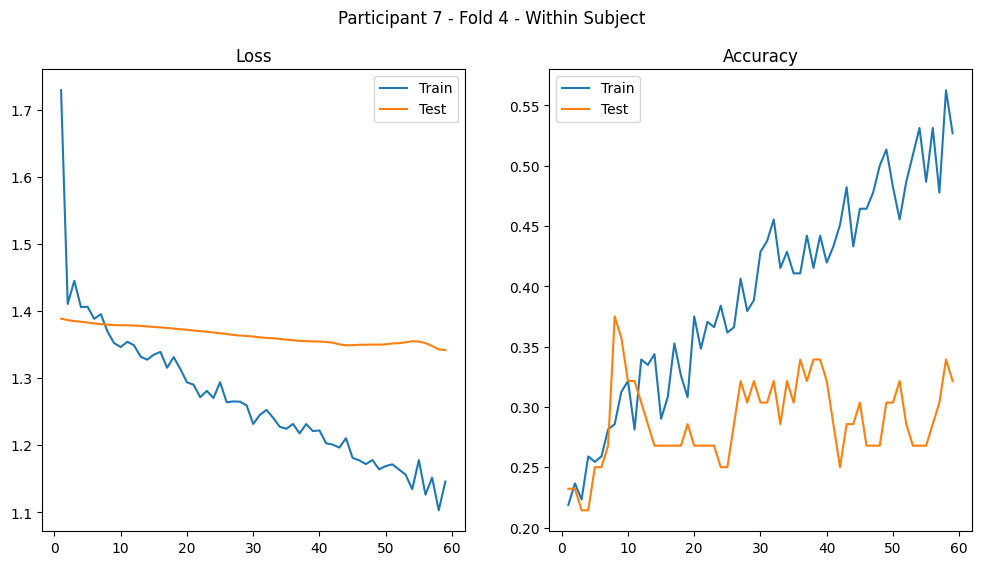

Outer Loop 5 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 206ms/step - loss: 1.6763 - accuracy: 0.2723 - val_loss: 1.3857 - val_accuracy: 0.2143
Epoch 2/500
4/4 [==============================] - 0s 72ms/step - loss: 1.4544 - accuracy: 0.2723 - val_loss: 1.3862 - val_accuracy: 0.2143
Epoch 3/500
4/4 [==============================] - 0s 66ms/step - loss: 1.4158 - accuracy: 0.2991 - val_loss: 1.3864 - val_accuracy: 0.2143
Epoch 4/500
4/4 [==============================] - 0s 67ms/step - loss: 1.3921 - accuracy: 0.3036 - val_loss: 1.3868 - val_accuracy: 0.1964
Ep

<Figure size 640x480 with 0 Axes>

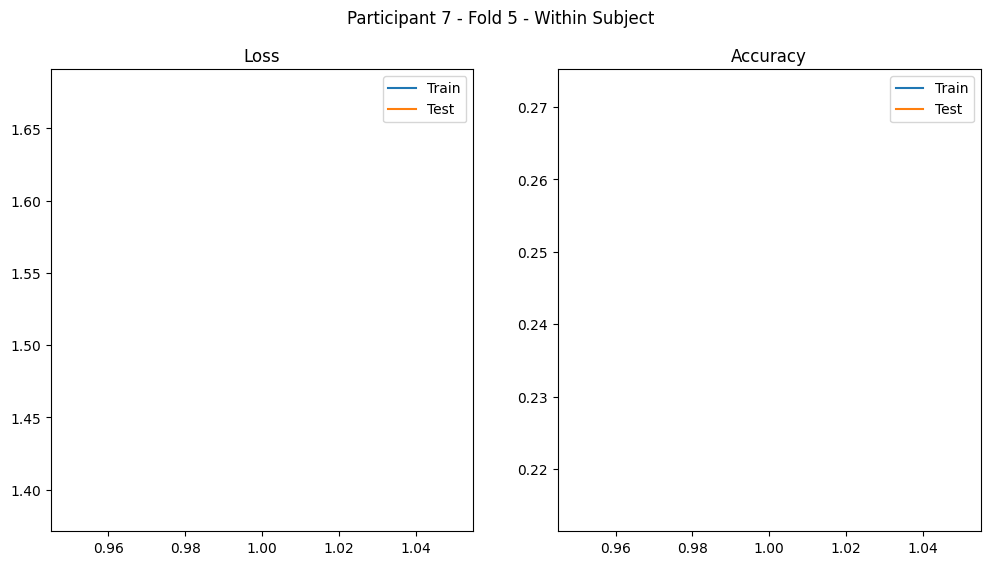

(160, 1)
Outer Loop 1 

      Train epochs' shape:                                (128, 1, 64, 1123)
      Test epochs' shape:                                 (32, 1, 64, 1123)
      Train labels' shape:                                (128, 4)
      Test labels' shape:                                 (32, 4)
      Train labels' shape (without encoding):             (128, 1)
      Test labels' shape (without encoding):              (32, 1)



Epoch 1/500
2/2 [==============================] - 2s 482ms/step - loss: 3.4493 - accuracy: 0.2656 - val_loss: 1.5447 - val_accuracy: 0.2500
Epoch 2/500
2/2 [==============================] - 0s 127ms/step - loss: 1.6537 - accuracy: 0.2734 - val_loss: 1.4999 - val_accuracy: 0.2500
Epoch 3/500
2/2 [==============================] - 0s 117ms/step - loss: 1.6514 - accuracy: 0.2812 - val_loss: 1.4752 - val_accuracy: 0.2500
Epoch 4/500
2/2 [==============================] - 0s 119ms/step - loss: 1.6032 - accuracy: 0.2578 - val_loss: 1.4599 - val_accurac

<Figure size 640x480 with 0 Axes>

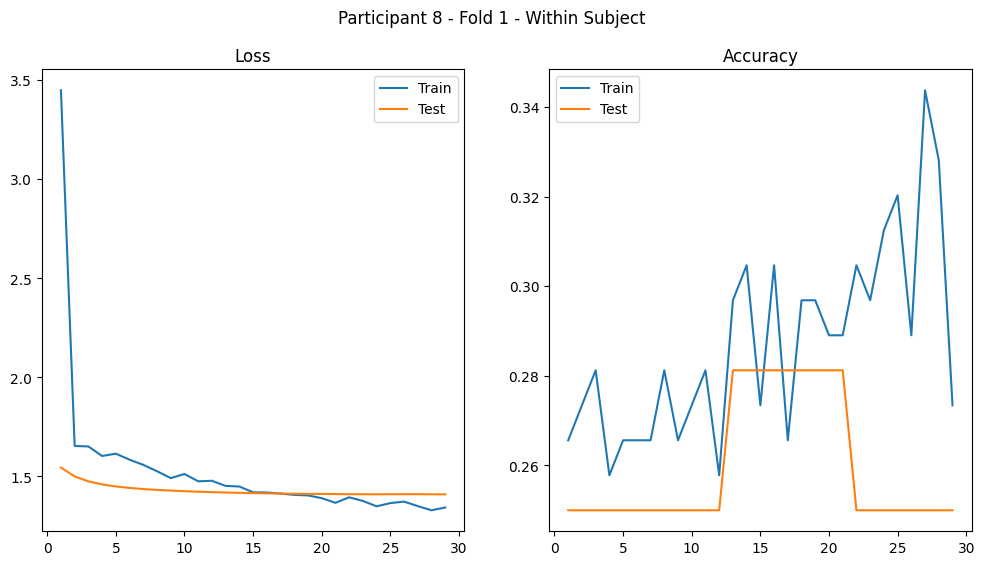

Outer Loop 2 

      Train epochs' shape:                                (128, 1, 64, 1123)
      Test epochs' shape:                                 (32, 1, 64, 1123)
      Train labels' shape:                                (128, 4)
      Test labels' shape:                                 (32, 4)
      Train labels' shape (without encoding):             (128, 1)
      Test labels' shape (without encoding):              (32, 1)



Epoch 1/500
2/2 [==============================] - 2s 514ms/step - loss: 2.2352 - accuracy: 0.2109 - val_loss: 1.4422 - val_accuracy: 0.2500
Epoch 2/500
2/2 [==============================] - 0s 162ms/step - loss: 1.5077 - accuracy: 0.2344 - val_loss: 1.4256 - val_accuracy: 0.2188
Epoch 3/500
2/2 [==============================] - 0s 130ms/step - loss: 1.5052 - accuracy: 0.2656 - val_loss: 1.4174 - val_accuracy: 0.2188
Epoch 4/500
2/2 [==============================] - 0s 122ms/step - loss: 1.5007 - accuracy: 0.2422 - val_loss: 1.4132 - val_accuracy: 0.2188

<Figure size 640x480 with 0 Axes>

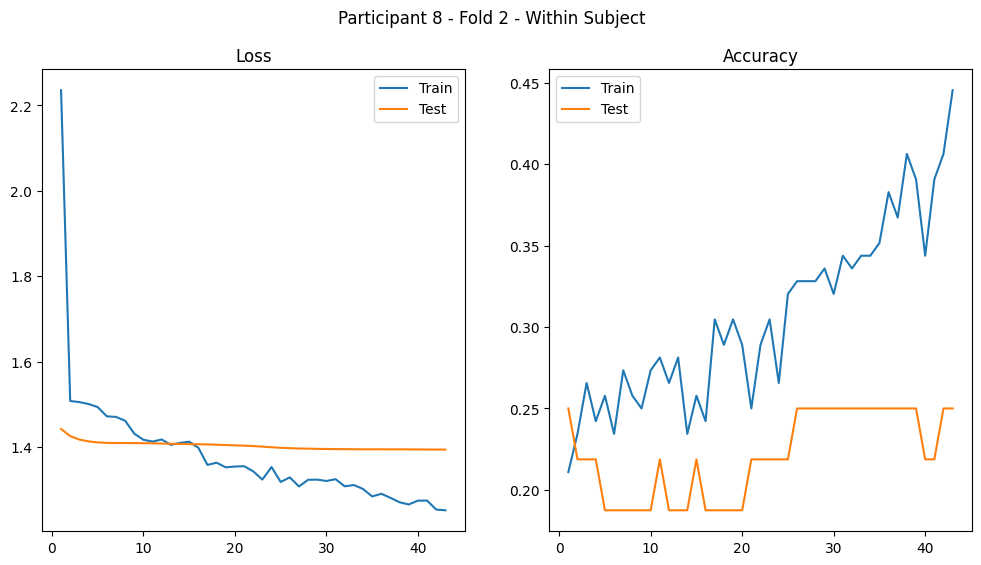

Outer Loop 3 

      Train epochs' shape:                                (128, 1, 64, 1123)
      Test epochs' shape:                                 (32, 1, 64, 1123)
      Train labels' shape:                                (128, 4)
      Test labels' shape:                                 (32, 4)
      Train labels' shape (without encoding):             (128, 1)
      Test labels' shape (without encoding):              (32, 1)



Epoch 1/500
2/2 [==============================] - 3s 1s/step - loss: 2.3560 - accuracy: 0.2656 - val_loss: 1.3832 - val_accuracy: 0.2812
Epoch 2/500
2/2 [==============================] - 0s 136ms/step - loss: 1.4736 - accuracy: 0.2109 - val_loss: 1.3835 - val_accuracy: 0.2500
Epoch 3/500
2/2 [==============================] - 0s 113ms/step - loss: 1.4738 - accuracy: 0.2578 - val_loss: 1.3845 - val_accuracy: 0.2188
Epoch 4/500
2/2 [==============================] - 0s 107ms/step - loss: 1.4425 - accuracy: 0.2656 - val_loss: 1.3854 - val_accuracy: 0.2188
Ep

<Figure size 640x480 with 0 Axes>

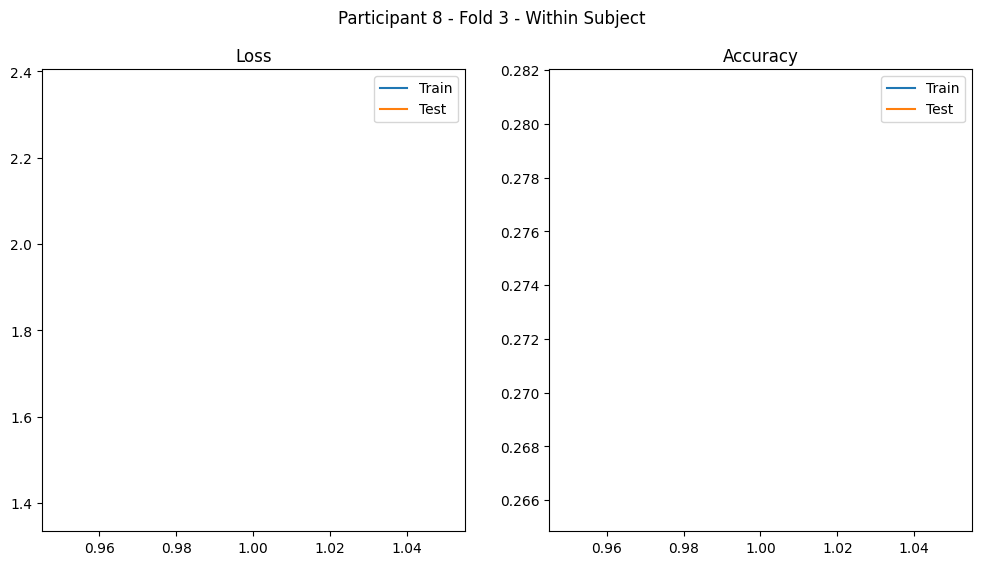

Outer Loop 4 

      Train epochs' shape:                                (128, 1, 64, 1123)
      Test epochs' shape:                                 (32, 1, 64, 1123)
      Train labels' shape:                                (128, 4)
      Test labels' shape:                                 (32, 4)
      Train labels' shape (without encoding):             (128, 1)
      Test labels' shape (without encoding):              (32, 1)



Epoch 1/500
2/2 [==============================] - 2s 492ms/step - loss: 2.6047 - accuracy: 0.3047 - val_loss: 1.5932 - val_accuracy: 0.1562
Epoch 2/500
2/2 [==============================] - 0s 141ms/step - loss: 1.5924 - accuracy: 0.2812 - val_loss: 1.5364 - val_accuracy: 0.1875
Epoch 3/500
2/2 [==============================] - 0s 119ms/step - loss: 1.5706 - accuracy: 0.3125 - val_loss: 1.5085 - val_accuracy: 0.1875
Epoch 4/500
2/2 [==============================] - 0s 106ms/step - loss: 1.5674 - accuracy: 0.3281 - val_loss: 1.4916 - val_accuracy: 0.1875

<Figure size 640x480 with 0 Axes>

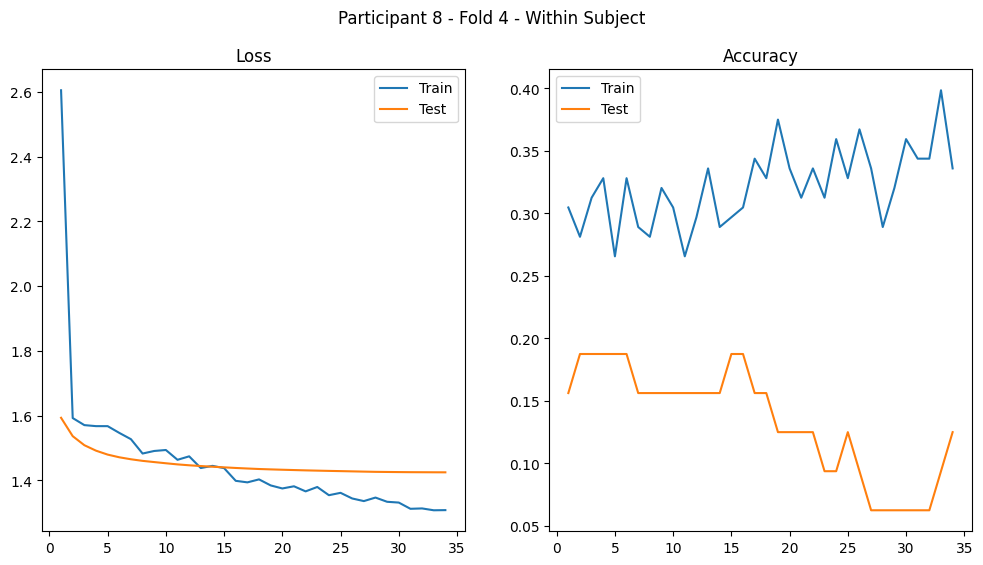

Outer Loop 5 

      Train epochs' shape:                                (128, 1, 64, 1123)
      Test epochs' shape:                                 (32, 1, 64, 1123)
      Train labels' shape:                                (128, 4)
      Test labels' shape:                                 (32, 4)
      Train labels' shape (without encoding):             (128, 1)
      Test labels' shape (without encoding):              (32, 1)



Epoch 1/500
2/2 [==============================] - 2s 467ms/step - loss: 2.6897 - accuracy: 0.3281 - val_loss: 1.5082 - val_accuracy: 0.2500
Epoch 2/500
2/2 [==============================] - 0s 129ms/step - loss: 1.4693 - accuracy: 0.3125 - val_loss: 1.4793 - val_accuracy: 0.2812
Epoch 3/500
2/2 [==============================] - 0s 112ms/step - loss: 1.5148 - accuracy: 0.2812 - val_loss: 1.4642 - val_accuracy: 0.2812
Epoch 4/500
2/2 [==============================] - 0s 112ms/step - loss: 1.4538 - accuracy: 0.2891 - val_loss: 1.4544 - val_accuracy: 0.2812

<Figure size 640x480 with 0 Axes>

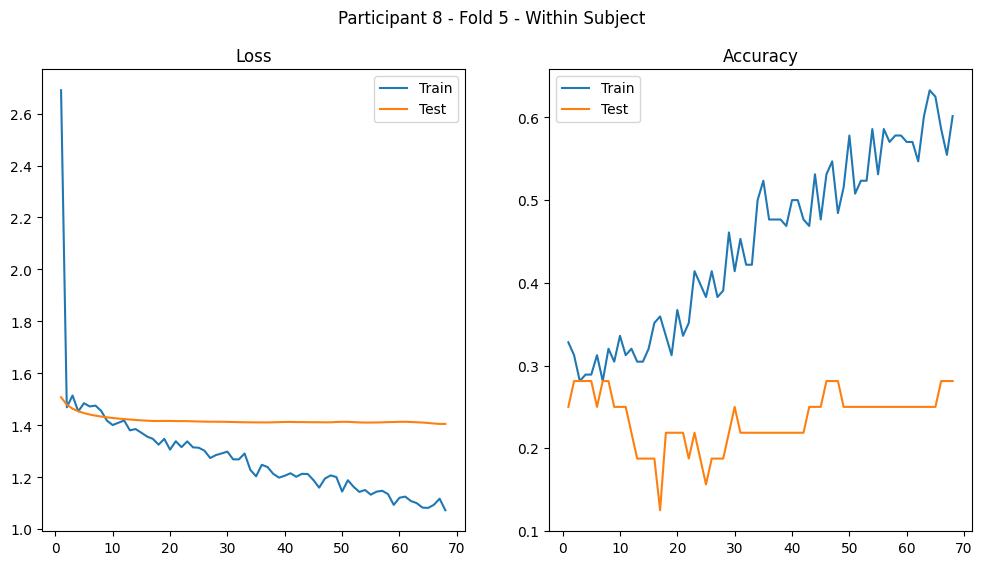

(280, 1)
Outer Loop 1 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 206ms/step - loss: 1.9855 - accuracy: 0.2366 - val_loss: 1.3979 - val_accuracy: 0.2143
Epoch 2/500
4/4 [==============================] - 0s 70ms/step - loss: 1.5275 - accuracy: 0.1875 - val_loss: 1.3952 - val_accuracy: 0.1786
Epoch 3/500
4/4 [==============================] - 0s 67ms/step - loss: 1.4824 - accuracy: 0.2366 - val_loss: 1.3935 - val_accuracy: 0.1429
Epoch 4/500
4/4 [==============================] - 0s 72ms/step - loss: 1.4874 - accuracy: 0.1920 - val_loss: 1.3927 - val_accuracy: 

<Figure size 640x480 with 0 Axes>

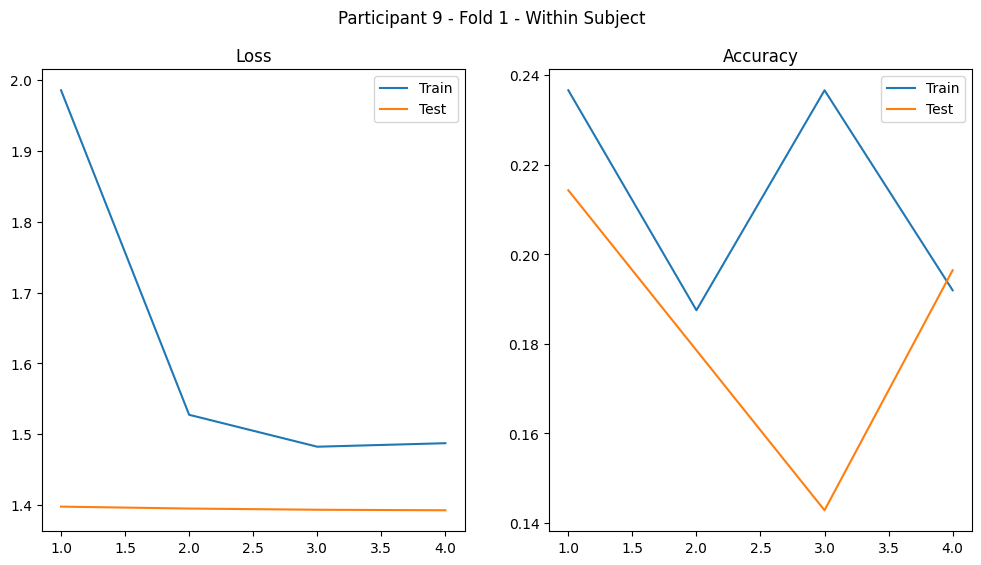

Outer Loop 2 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 215ms/step - loss: 2.4455 - accuracy: 0.1875 - val_loss: 1.3956 - val_accuracy: 0.3571
Epoch 2/500
4/4 [==============================] - 0s 71ms/step - loss: 1.5441 - accuracy: 0.2277 - val_loss: 1.3908 - val_accuracy: 0.3393
Epoch 3/500
4/4 [==============================] - 0s 73ms/step - loss: 1.5247 - accuracy: 0.2277 - val_loss: 1.3893 - val_accuracy: 0.3214
Epoch 4/500
4/4 [==============================] - 0s 72ms/step - loss: 1.5105 - accuracy: 0.2634 - val_loss: 1.3878 - val_accuracy: 0.3393
Ep

<Figure size 640x480 with 0 Axes>

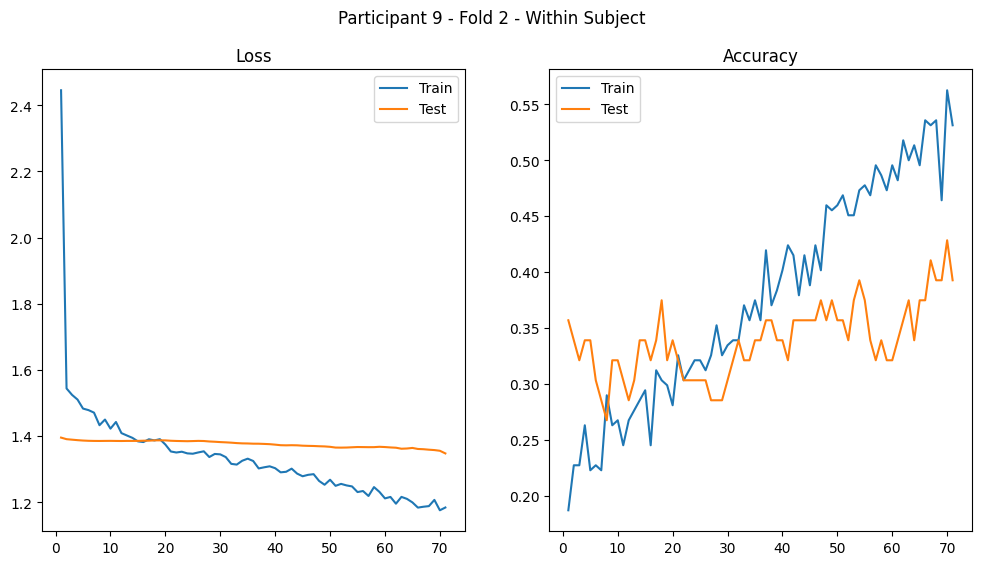

Outer Loop 3 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 216ms/step - loss: 1.5755 - accuracy: 0.2411 - val_loss: 1.4203 - val_accuracy: 0.2321
Epoch 2/500
4/4 [==============================] - 0s 73ms/step - loss: 1.4367 - accuracy: 0.2455 - val_loss: 1.4175 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 69ms/step - loss: 1.4051 - accuracy: 0.2723 - val_loss: 1.4158 - val_accuracy: 0.2143
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 1.3972 - accuracy: 0.2946 - val_loss: 1.4141 - val_accuracy: 0.1964
Ep

<Figure size 640x480 with 0 Axes>

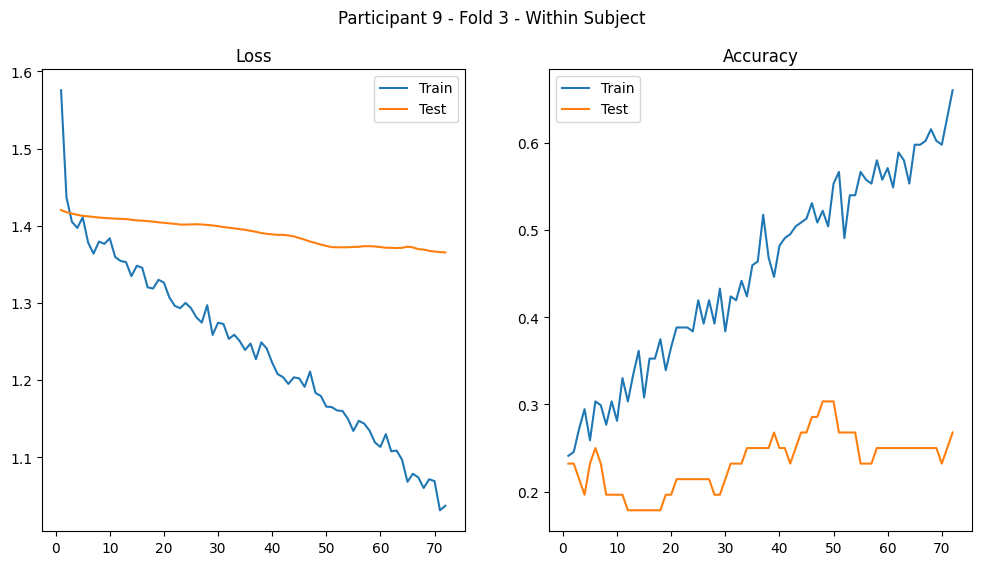

Outer Loop 4 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 211ms/step - loss: 1.6363 - accuracy: 0.2277 - val_loss: 1.3916 - val_accuracy: 0.2143
Epoch 2/500
4/4 [==============================] - 0s 75ms/step - loss: 1.4239 - accuracy: 0.2411 - val_loss: 1.3909 - val_accuracy: 0.1964
Epoch 3/500
4/4 [==============================] - 0s 68ms/step - loss: 1.4477 - accuracy: 0.2545 - val_loss: 1.3911 - val_accuracy: 0.1964
Epoch 4/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4196 - accuracy: 0.3036 - val_loss: 1.3907 - val_accuracy: 0.1964
Ep

<Figure size 640x480 with 0 Axes>

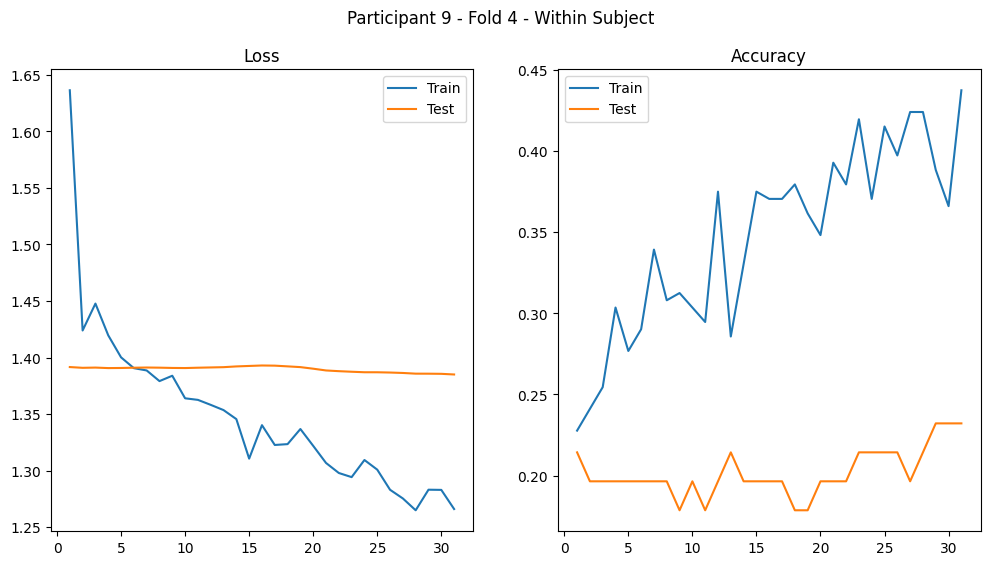

Outer Loop 5 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 205ms/step - loss: 2.1376 - accuracy: 0.2366 - val_loss: 1.4001 - val_accuracy: 0.2143
Epoch 2/500
4/4 [==============================] - 0s 73ms/step - loss: 1.5288 - accuracy: 0.2366 - val_loss: 1.3955 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 70ms/step - loss: 1.5025 - accuracy: 0.2455 - val_loss: 1.3927 - val_accuracy: 0.2321
Epoch 4/500
4/4 [==============================] - 0s 73ms/step - loss: 1.5013 - accuracy: 0.2232 - val_loss: 1.3912 - val_accuracy: 0.2143
Ep

<Figure size 640x480 with 0 Axes>

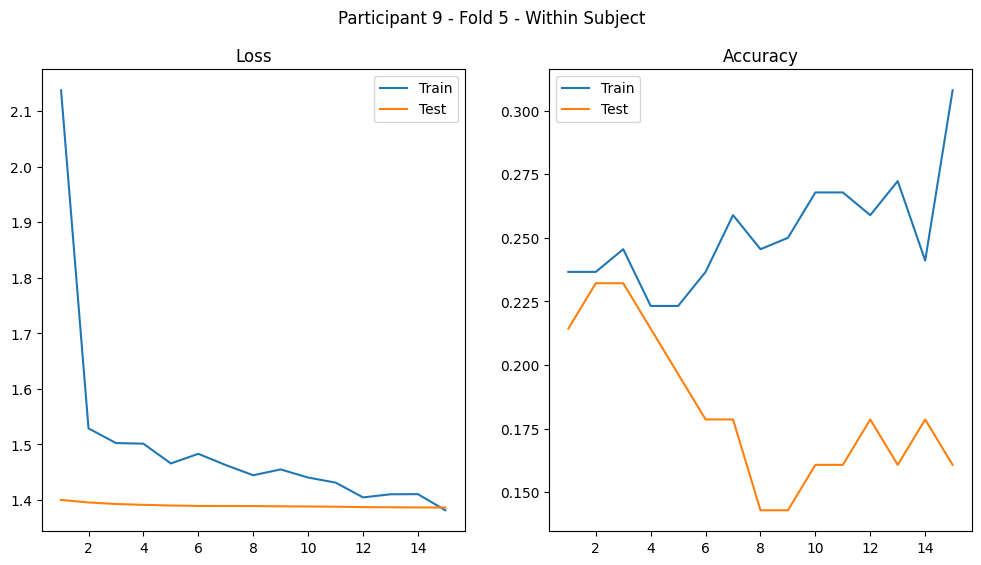

(280, 1)
Outer Loop 1 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 224ms/step - loss: 1.8270 - accuracy: 0.2277 - val_loss: 1.4169 - val_accuracy: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 71ms/step - loss: 1.5071 - accuracy: 0.2366 - val_loss: 1.4048 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 71ms/step - loss: 1.4727 - accuracy: 0.2545 - val_loss: 1.4008 - val_accuracy: 0.2500
Epoch 4/500
4/4 [==============================] - 0s 73ms/step - loss: 1.4369 - accuracy: 0.2902 - val_loss: 1.3986 - val_accuracy: 

<Figure size 640x480 with 0 Axes>

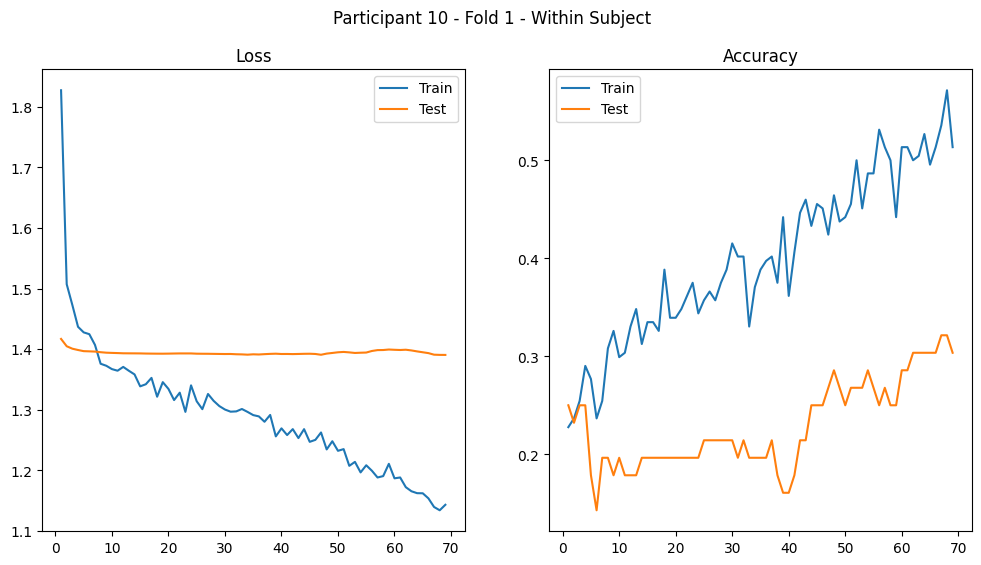

Outer Loop 2 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 224ms/step - loss: 1.9252 - accuracy: 0.2232 - val_loss: 1.3931 - val_accuracy: 0.2321
Epoch 2/500
4/4 [==============================] - 0s 67ms/step - loss: 1.4573 - accuracy: 0.2500 - val_loss: 1.3934 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 65ms/step - loss: 1.4500 - accuracy: 0.2634 - val_loss: 1.3937 - val_accuracy: 0.2143
Epoch 4/500
4/4 [==============================] - 0s 66ms/step - loss: 1.4355 - accuracy: 0.2277 - val_loss: 1.3940 - val_accuracy: 0.2143
Ep

<Figure size 640x480 with 0 Axes>

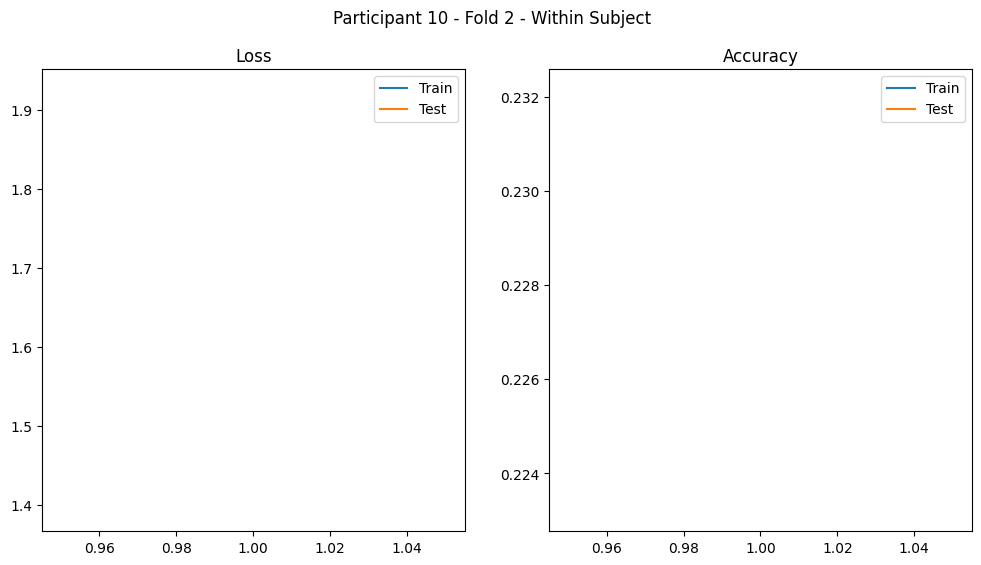

Outer Loop 3 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 3s 219ms/step - loss: 1.5520 - accuracy: 0.2277 - val_loss: 1.4050 - val_accuracy: 0.3036
Epoch 2/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4439 - accuracy: 0.2545 - val_loss: 1.4028 - val_accuracy: 0.1964
Epoch 3/500
4/4 [==============================] - 0s 68ms/step - loss: 1.3984 - accuracy: 0.3036 - val_loss: 1.4030 - val_accuracy: 0.2143
Epoch 4/500
4/4 [==============================] - 0s 68ms/step - loss: 1.4166 - accuracy: 0.2143 - val_loss: 1.4034 - val_accuracy: 0.2321
Ep

<Figure size 640x480 with 0 Axes>

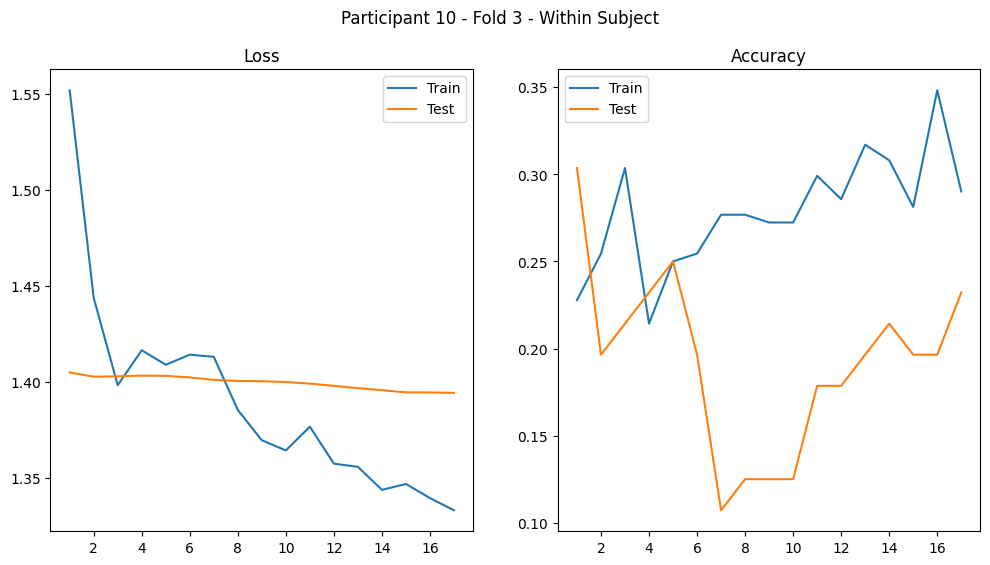

Outer Loop 4 

      Train epochs' shape:                                (224, 1, 64, 1123)
      Test epochs' shape:                                 (56, 1, 64, 1123)
      Train labels' shape:                                (224, 4)
      Test labels' shape:                                 (56, 4)
      Train labels' shape (without encoding):             (224, 1)
      Test labels' shape (without encoding):              (56, 1)



Epoch 1/500
4/4 [==============================] - 2s 217ms/step - loss: 1.8267 - accuracy: 0.2589 - val_loss: 1.3983 - val_accuracy: 0.2321
Epoch 2/500
4/4 [==============================] - 0s 74ms/step - loss: 1.4684 - accuracy: 0.2545 - val_loss: 1.3969 - val_accuracy: 0.2321
Epoch 3/500
4/4 [==============================] - 0s 73ms/step - loss: 1.4261 - accuracy: 0.2634 - val_loss: 1.3964 - val_accuracy: 0.2321
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 1.4161 - accuracy: 0.2679 - val_loss: 1.3960 - val_accuracy: 0.2143
Ep

In [ ]:
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0009




for j in range(num_subjects):
    
    epochs_subject = all_data_epochs[j]
    labels_subject = encoded[j]
    labels_subject_no_encode = no_encode[j]
    
    print(labels_subject_no_encode.shape)
    
    kf_outer2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    tests_pred = []
    tests_true = []
    
    for i, (train_index, test_index) in enumerate(kf_outer2.split(epochs_subject, labels_subject_no_encode[:, 0])):



        train_epochs = np.array([epochs_subject[j] for j in train_index])
        test_epochs = np.array([epochs_subject[k] for k in test_index])
        train_labels = np.array([labels_subject[l] for l in train_index])
        test_labels = np.array([labels_subject[m] for m in test_index])
        no_encoded_train_labels = np.array([labels_subject_no_encode[n] for n in train_index])
        no_encoded_test_labels = np.array([labels_subject_no_encode[o] for o in test_index])
        


        print("Outer Loop {}".format(i+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        print("      Train labels' shape:                               ", train_labels.shape)
        print("      Test labels' shape:                                ", test_labels.shape)
        print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

        print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)

        print('\n\n')


        # Create the EEG-TCNet model
        model = EEGTCNet(nb_classes=4,Chans=64, Samples=1123, layers=3, 
                     kernel_s=10,filt=10, dropout=0, activation='relu', 
                     F1=4, D=2, kernLength=64, dropout_eeg=0.1)

        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0003), metrics=['accuracy'])

        patience = 100
        train_loss_epochs = []
        train_acc_epochs = []
        test_loss_epochs = []
        test_acc_epochs = []
        train_conf_mat = []

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


        # # Normalizing the features
        # mean = train_epochs.mean(axis=(0, 3), keepdims=True)
        # std = train_epochs.std(axis=(0, 3), keepdims=True)

        # print(mean.shape)
        # print(std.shape)

        # norm_train_epochs = (train_epochs - mean) / std
        # norm_test_epochs = (test_epochs - mean) / std
        

        # Train the model
        history = model.fit(
            train_epochs, train_labels,
            validation_data=(test_epochs, test_labels),
            epochs=max_epochs,
            batch_size=64,  # Adjust as needed
            callbacks=[early_stopping]
        )

        y_pred_test = model.predict(test_epochs)
        y_true_test = test_labels

        

        # Collect training metrics
        train_loss_epochs.extend(history.history['loss'])
        train_acc_epochs.extend(history.history['accuracy'])

        # Collect testing metrics
        test_loss_epochs.extend(history.history['val_loss'])
        test_acc_epochs.extend(history.history['val_accuracy'])

        epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)

        plt.figure(figsize=(12, 6))
        plt.suptitle("Participant {} - Fold {} - Within Subject".format(j+1, i+1))

        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(epochs_range, train_loss_epochs[:-1*patience])
        plt.plot(epochs_range, test_loss_epochs[:-1*patience])
        plt.legend(["Train", "Test"])

        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(epochs_range, train_acc_epochs[:-1*patience])
        plt.plot(epochs_range, test_acc_epochs[:-1*patience])
        plt.legend(["Train", "Test"])
        plt.savefig("P{}_F{}_WS.jpg".format(j+1, i+1))
        plt.show()
        plt.clf()
        
        tests_pred.extend(y_pred_test)
        tests_true.extend(y_true_test)
    
    with open("y_pred_ParID_{}_ws.pickle".format(j+1), 'wb') as f:
        pickle.dump(tests_pred, f)

    with open("y_true_ParID_{}_ws.pickle".format(j+1), 'wb') as f:
        pickle.dump(tests_true, f)
        
    all_tests_pred.append(tests_pred)
    all_tests_true.append(tests_true)


In [83]:
participants[0]

1

In [ ]:
print(len(all_tests_pred))

In [20]:
print(np.concatenate(all_tests_pred[4]).shape)

(288,)


In [ ]:
confusion_matrices = []
all_y_pred = []
all_y_true = []

for i in range(1, 15):
    
    with open("y_pred_ParID_{}_ws.pickle".format(i), 'rb') as f:
        all_y_pred.append(pickle.load(f))
        
        
    with open("y_true_ParID_{}_ws.pickle".format(i), 'rb') as f:
        all_y_true.append(pickle.load(f))
    
    y_true = np.array(all_y_true[i-1])
    y_pred = np.array(all_y_pred[i-1])
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [44]:
confusion_matrices[3]

array([[40,  8, 11, 10],
       [ 8, 41, 13,  8],
       [ 8, 24, 29,  9],
       [20, 21,  9, 20]])

In [98]:
del confusion_matrices[3]

In [99]:
confusion_matrices[3]

array([[63,  1,  5,  3],
       [ 1, 60,  1, 10],
       [ 5,  4, 56,  7],
       [ 3,  7, 13, 49]])

In [90]:
print(confusion_matrices[1])

[[44 14  9  5]
 [14 36 11 11]
 [ 5  3 60  4]
 [ 7  6  2 57]]


In [47]:
print(len(confusion_matrices))

14


In [ ]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)'])
normalized = summation.div(summation.sum(axis=1), axis=0)
acc = normalized.values.trace() / 4


In [ ]:
print("Dataset: Hadi - Phase I")
print("The within-subject scenario:")
print("Algorithm: EEG-TCNet")
print("Accuracy: ", acc)

normalized

In [26]:
summation.sum(axis=1)

Left (True)      576
Right (True)     576
Feet (True)      576
Tongue (True)    576
dtype: int64

In [27]:
np.sum(summation / 576 * np.eye(4, 4)).sum() / 4

C:\ProgramData\Anaconda3\envs\BCI_2\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0.74609375

# Cross-subjects (With hyperparameter tuning):

In [27]:
participants = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.001
patience = 100


kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.



for i, (train_index, test_index) in enumerate(kf_outer2.split(all_data_epochs)):
    
    
    
    train_epochs = np.concatenate([all_data_epochs[j] for j in train_index])
    test_epochs = np.concatenate([all_data_epochs[k] for k in test_index])
    train_labels = np.concatenate([encoded[l] for l in train_index])
    test_labels = np.concatenate([encoded[m] for m in test_index])
    no_encoded_train_labels = np.concatenate([no_encode[n] for n in train_index])
    no_encoded_test_labels = np.concatenate([no_encode[o] for o in test_index])
    train_ids_for_save = [participants[i] for i in train_index]
    test_ids_for_save = [participants[i] for i in test_index]
    
    
    print("Outer Loop {}".format(i+1), "\n")
    print("      Train epochs' shape:                               ", train_epochs.shape)

    print("      Test epochs' shape:                                ", test_epochs.shape)
    print("      Test labels' shape:                                ", test_labels.shape)
    print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

    print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)
    print("      Train index:                                       ", train_ids_for_save)

    print("      Test index:                                        ", test_ids_for_save)
    print('\n\n')
    
    # Define early stopping
    # early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # All_models = KerasClassifier(model=EEGNet_Modified, epochs=1, 
    #                              nb_classes=4, Chans=64, Samples=1123, dropoutRate=0.4, 
    #                              kernLength=64, F1=8, D=4, F2=32, norm_rate=0.25, dropoutType=Dropout,
    #                              learning_rate=0.0009)

    
    
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    train_conf_mat = []
    
    # # Define hyperparameters and values to search
    # param_grid = {
    #     'nb_classes': [4],
    #     'Chans': [64],
    #     'Samples': [1123],
    #     'dropoutRate': [0.2, 0.4, 0.5],
    #     'kernLength': [32, 64, 125, 150, 300, 500],
    #     'F1': [8],
    #     'D': [4],
    #     'F2': [32],
    #     'norm_rate': [0.25],
    #     'dropoutType': ['Dropout'],
    #     'learning_rate': [0.005],
    # }
    
    
    # Normalizing the features
#     mean = train_epochs.mean(axis=(0, 2, 3), keepdims=True)
#     std = train_epochs.std(axis=(0, 2, 3), keepdims=True)
    
#     print(mean.shape)
#     print(std.shape)
    
    # norm_train_epochs = (train_epochs - mean) / std
    # norm_test_epochs = (test_epochs - mean) / std
    
    
    
    # random_search = RandomizedSearchCV(estimator=All_models, param_distributions=param_grid, cv=2, verbose=1, n_iter=1)
   
    
#     RS_result = random_search.fit(norm_train_epochs, train_labels)
    
#     best_parameters = RS_result.best_params_
    
    
#     print("--------Best Parammeters for this set----------\n\n")
#     print("         ", best_parameters, '\n\n')
#     print("-------------------END-------------------------")
#     with open("Best_hyperparameters_CS_Hadi.txt", 'a') as f:
#         json_string = json.dumps(best_parameters)
#         f.write('\n' + json_string)
#         f.close()
    
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    
#     best_model = EEGNet_Modified(**best_parameters)
    
    # history = best_model.fit(
    #     norm_train_epochs, train_labels,
    #     validation_data=(norm_test_epochs, test_labels),
    #     epochs=max_epochs,
    #     batch_size=32,  # Adjust as needed
    #     callbacks=[early_stopping]
    # )
    
    # trans_train_epochs = np.transpose(norm_train_epochs, (0, 2, 1, 3)).squeeze()
    # trans_test_epochs = np.transpose(norm_test_epochs, (0, 2, 1, 3)).squeeze()
    
    # Create the EEG-TCNet model
    model = EEGTCNet(nb_classes=4,Chans=64, Samples=1123, layers=3, 
                     kernel_s=10,filt=10, dropout=0, activation='relu', 
                     F1=4, D=2, kernLength=64, dropout_eeg=0.1)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    
    history = model.fit(
        train_epochs, train_labels,
        validation_data=(test_epochs, test_labels),
        epochs=max_epochs,
        batch_size=64,  # Adjust as needed
        callbacks=[early_stopping]
    )
    
    # y_pred_test = best_model.predict(norm_test_epochs)
    # y_true_test = test_labels
    
    y_pred_test = model.predict(test_epochs)
    y_true_test = test_labels
    
    with open("y_pred_testID_{}.pickle".format(participants[test_index[0]]), 'wb') as f:
        pickle.dump(y_pred_test, f)
    
    with open("y_true_testID_{}.pickle".format(participants[test_index[0]]), 'wb') as f:
        pickle.dump(y_true_test, f)
    
    # Collect training metrics
    train_loss_epochs.extend(history.history['loss'])
    train_acc_epochs.extend(history.history['accuracy'])

    # Collect testing metrics
    test_loss_epochs.extend(history.history['val_loss'])
    test_acc_epochs.extend(history.history['val_accuracy'])
    
    epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)
    
    plt.figure(figsize=(12, 6))
    plt.suptitle("Participant {}".format(participants[test_index[0]]))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(epochs_range, train_loss_epochs[:-1*patience])
    plt.plot(epochs_range, test_loss_epochs[:-1*patience])
    plt.legend(["Train", "Test"])

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(epochs_range, train_acc_epochs[:-1*patience])
    plt.plot(epochs_range, test_acc_epochs[:-1*patience])
    plt.legend(["Train", "Test"])
    plt.savefig("P{}.jpg".format(participants[test_index[0]]))
    plt.show()
    plt.clf()

Outer Loop 1 

      Train epochs' shape:                                (3516, 1, 64, 1123)
      Test epochs' shape:                                 (279, 1, 64, 1123)
      Test labels' shape:                                 (279, 4)
      Train labels' shape (without encoding):             (3516, 1)
      Test labels' shape (without encoding):              (279, 1)
      Train index:                                        [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
      Test index:                                         [13]



Epoch 1/500
55/55 [==============================] - 6s 79ms/step - loss: 1.4280 - accuracy: 0.2511 - val_loss: 1.3876 - val_accuracy: 0.2079
Epoch 2/500
55/55 [==============================] - 4s 66ms/step - loss: 1.3856 - accuracy: 0.2719 - val_loss: 1.3840 - val_accuracy: 0.2832
Epoch 3/500
55/55 [==============================] - 4s 66ms/step - loss: 1.3815 - accuracy: 0.2782 - val_loss: 1.3858 - val_accuracy: 0.2616
Epoch 4/500
55/55 [==============

KeyboardInterrupt: 

In [32]:
best_estimator

<function __main__.EEGNet(nb_classes, Chans=64, Samples=128, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout', learning_rate=0.0009)>

In [28]:
RS_result.best_params_

{'norm_rate': 0.25,
 'nb_classes': 4,
 'learning_rate': 0.005,
 'kernLength': 64,
 'dropoutType': 'SpatialDropout2D',
 'dropoutRate': 0.4,
 'Samples': 1123,
 'F2': 16,
 'F1': 8,
 'D': 2,
 'Chans': 64}

In [36]:
All_models.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'nb_epochs', 'class_weight'])

In [41]:
print(All_models.get_params().keys())


dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'nb_classes', 'Chans', 'Samples', 'class_weight'])


In [38]:
confusion_matrices = []
all_y_pred = []
all_y_true = []

for i in range(2, 16):
    with open("y_pred_testID_{}.pickle".format(i), 'rb') as f:
        all_y_pred.append(pickle.load(f))
        
        
    with open("y_true_testID_{}.pickle".format(i), 'rb') as f:
        all_y_true.append(pickle.load(f))
        
    y_true = all_y_true[i-2]
    y_pred = all_y_pred[i-2]
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [39]:
len(confusion_matrices)

14

In [40]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)'])
normalized = summation.div(summation.sum(axis=1), axis=0)
acc = normalized.values.trace() / 4


In [31]:
summation.sum(axis=1)

Left (True)      599
Right (True)     602
Feet (True)      601
Tongue (True)    602
dtype: int64

In [32]:
acc

0.40595844816807775

In [41]:
print("Dataset: Hadi - Phase 1")
print("The cross-subject scenario:")
print("Algorithm: EEGNet")
print("Accuracy: ", acc)

normalized

Dataset: Hadi - Phase 1
The cross-subject scenario:
Algorithm: EEGNet
Accuracy:  0.27893374741200827


Left (Pred)  Right (Pred)  Feet (Pred)  Tongue (Pred)
Left (True)       0.471429      0.500000     0.000000       0.028571
Right (True)      0.428571      0.542857     0.014286       0.014286
Feet (True)       0.457143      0.514286     0.000000       0.028571
Tongue (True)     0.130435      0.724638     0.043478       0.101449

In [72]:
np.argmax([1, 1, 2, 2, 3, 3, 3, 1])

4

# Test for the effect of calibration:

In [32]:
models = []
Calibrated_model = []
for file in os.listdir("/home/bijan/py3x"):
    if file.endswith(".h5") and file.startswith("Calibrated"):
        Calibrated_model.append(file)
    elif file.endswith(".h5") and file.startswith("Model"):
        models.append(file)
        
Calibrated_model = sorted(Calibrated_model)
models = sorted(models)

In [49]:
models = {}
Calibrated_models = {}
for i in range(14):
    if i == 8:
        continue
        
    for j in range(6):
        #print("Model{}{}.h5".format(i+1, j+1))
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)

In [50]:
"{:02}{:02}".format(2, 3)

'0203'

In [51]:
models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [52]:
Calibrated_models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_subjects = len(EEG_epochs)
all_tests_true = []
all_tests_pred = []
models = {}
Calibrated_models = {}

kf_outer1 = KFold(n_splits=6, shuffle=True, random_state=42)              # Split the data into Train and Cross-Validation sets
kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.


for i, (train_crossval_index, test_index) in enumerate(kf_outer2.split(EEG_epochs)):
    
    if test_index == 7:
        continue
    
    train_crossval = [EEG_epochs[i] for i in train_crossval_index]
    test_epochs = np.concatenate([EEG_epochs[i] for i in test_index])
    train_crossval_labels = [encoded[i] for i in train_crossval_index]
    test_labels = np.concatenate([encoded[i] for i in test_index])
    no_encoded_train_crossval = [no_encode[i] for i in train_crossval_index]
    no_encoded_test = np.concatenate([no_encode[i] for i in test_index])

    temp_pred = []
    temp_true = []

    for j, (train_index, val_index) in enumerate(kf_outer1.split(train_crossval)):
        
        
        train_epochs = np.concatenate([train_crossval[i] for i in train_index])
        crossval_epochs = np.concatenate([train_crossval[i] for i in val_index])
        train_labels = np.concatenate([train_crossval_labels[i] for i in train_index])
        crossval_labels = np.concatenate([train_crossval_labels[i] for i in val_index])
        no_encoded_train = np.concatenate([no_encoded_train_crossval[i] for i in train_index])
        no_encoded_crossval = np.concatenate([no_encoded_train_crossval[i] for i in val_index])
        train_ids_for_save = [train_crossval_index[i] for i in train_index]
        cross_val_ids_for_save = [train_crossval_index[i] for i in val_index]
        
        
        print("Outer Loop {} and Inner Loop {}:".format(i+1, j+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        #print("     Train labels' shape:                               ", train_labels.shape)
        print("      Cross-validation epochs' shape:                    ", crossval_epochs.shape)
        #print("     Cross-validation labels' shape:                    ", crossval_labels.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        #print("     Test labels' shape:                                ", test_labels.shape)
        #print("     Train labels' shape (without encoding):            ", no_encoded_train.shape)
        #print("     Cross-validation labels' shape (without encoding): ", no_encoded_crossval.shape)
        #print("     Test labels' shape (without encoding):             ", no_encoded_test.shape)
        print("      Train index:                                      ", train_ids_for_save)
        print("      Cross-validation index:                           ", cross_val_ids_for_save)
        print("      Test index:                                       ", test_index)
        print('\n\n')
        
        original_stdout = sys.stdout
        sys.stdout = open('temp_stdout{}.txt'.format(i), 'w')  # Redirect output to a temporary file
        train_features, CrossVal_features, test_features = feature_extraction_cv(train_epochs, no_encoded_train, crossval_epochs, test_epochs, number_of_bands=9, sampling_freq=250, low_cutoff=0, number_of_components=64)
        sys.stdout.close()
        sys.stdout = original_stdout
    
        print("Train features shape:            ", train_features.shape)
        print("Cross-validation features shape: ", CrossVal_features.shape)
        print("Test features shape:             ", test_features.shape)
    
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)
        
        temp_pred.append(models["{:02}{:02}".format(i+1, j+1)].predict(test_features[60:]))
        temp_true.append(test_labels[60:])
        
    all_tests_pred.append(temp_pred)
    all_tests_true.append(temp_true)
    


Outer Loop 1 and Inner Loop 1: 

      Train epochs' shape:                                (1337, 64, 1123)
      Cross-validation epochs' shape:                     (420, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [1, 2, 3, 4, 5, 6, 7, 8, 10, 13]
      Cross-validation index:                            [0, 9, 12]
      Test index:                                        [11]



Train features shape:             (1337, 576)
Cross-validation features shape:  (420, 576)
Test features shape:              (140, 576)
Outer Loop 1 and Inner Loop 2: 

      Train epochs' shape:                                (1477, 64, 1123)
      Cross-validation epochs' shape:                     (280, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [0, 1, 2, 3, 4, 6, 7, 9, 10, 12, 13]
      Cross-validation index:      

In [26]:
import pickle
with open("all_tests_pred_without_calibration", "wb") as fp:
    pickle.dump(all_tests_pred, fp)

with open("all_tests_true_without_calibration", "wb") as fp:
    pickle.dump(all_tests_true, fp)

In [27]:
confusion_matrices_ap = []
for i in range(len(all_tests_pred)):
    for j in range(len(all_tests_pred[1])):
        y_true = 2 - np.argmax(all_tests_true[i][j], axis=1)
        y_pred = 2 - np.argmax(all_tests_pred[i][j], axis=1)
    confusion_matrices_ap.append(confusion_matrix(y_true, y_pred))

In [28]:
summation = pd.DataFrame(sum(confusion_matrices_ap), index=['class 1 (True)', 'class 2 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)'])
summation

class 1 (Pred)  class 2 (Pred)
class 1 (True)             358             162
class 2 (True)             202             315

In [31]:
summation / 520

class 1 (Pred)  class 2 (Pred)
class 1 (True)        0.688462        0.311538
class 2 (True)        0.388462        0.605769

In [29]:
mean_confusion_matrix = sum(confusion_matrices_ap) / len(confusion_matrices_ap)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]
 
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")


Average metrics for binary classification (Left vs Right hand):


       Accuracy:                  0.65

       Precision:                 0.66

       Recall (Sensitivity):      0.61     

       F1 Score:                  0.63



# Test of the functions:

In [37]:
a = np.random.rand(200, 4, 22, 250)
b = np.random.randint(0, 3, (200, 1))
c = np.random.rand(50, 4, 22, 250)

In [ ]:
train_features, test_features = feature_extraction_4(a, b, c, sampling_freq=250)

In [43]:
train_features.shape

(800, 80)

In [45]:
test_features.shape

(200, 80)

# Filter validation:

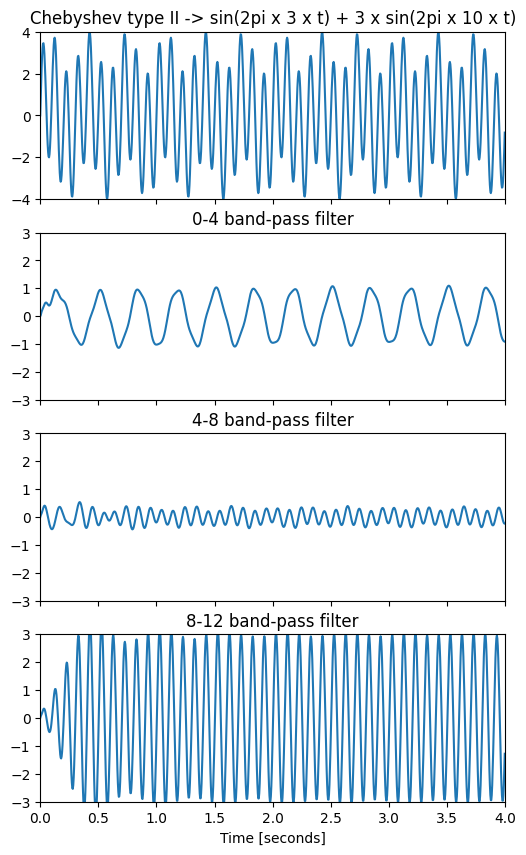

In [85]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig)
ax1.set_title('Chebyshev type II -> sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t)')
ax1.axis([0, 1, -4, 4])

sos1 = signal.cheby2(15, 20, [0.1, 4], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos1, sig)
ax2.plot(t, filtered)
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

sos2 = signal.cheby2(10, 20, [4, 8], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos2, sig)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

sos3 = signal.cheby2(10, 20, [8, 12], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos3, sig)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
--------------

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


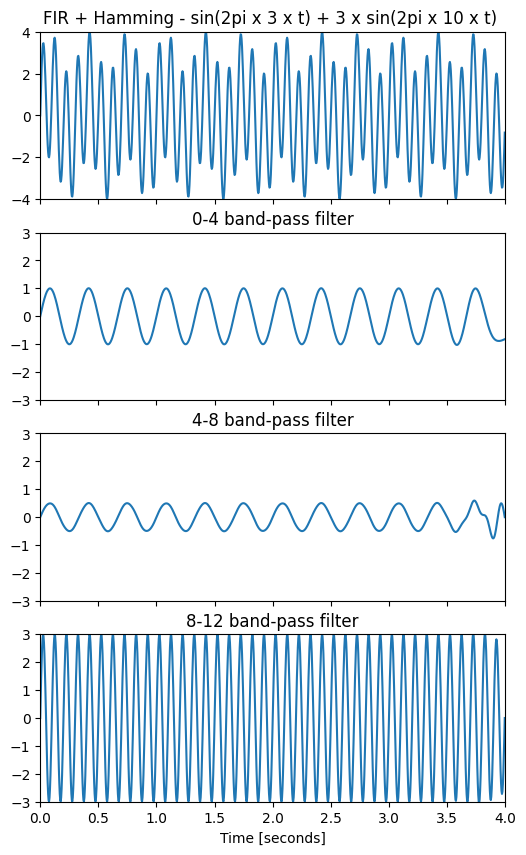

In [86]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig)
ax1.set_title('FIR + Hamming - sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t) ')
ax1.axis([0, 1, -4, 4])


filtered = mne.filter.filter_data(sig, 250, 0, 4)
ax2.plot(t, filtered)
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

filtered = mne.filter.filter_data(sig, 250, 4, 8)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

filtered = mne.filter.filter_data(sig, 250, 8, 12)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (3, 1000)

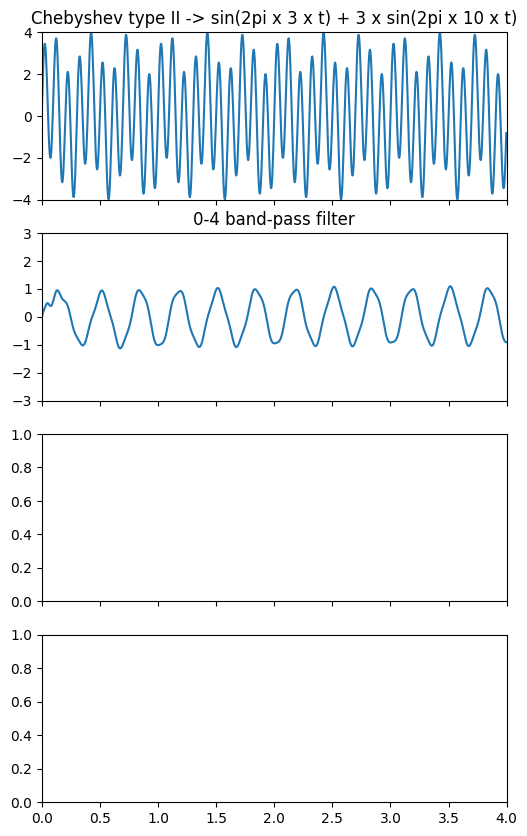

In [29]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)

sig = np.tile(sig, (3, 1))

print(sig.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig[0])
ax1.set_title('Chebyshev type II -> sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t)')
ax1.axis([0, 1, -4, 4])

sos1 = signal.cheby2(15, 20, [0.1, 4], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos1, sig)
ax2.plot(t, filtered[0])
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

sos2 = signal.cheby2(10, 20, [4, 8], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos2, sig)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

sos3 = signal.cheby2(10, 20, [8, 12], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos3, sig)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

# CSP Validation:

In [199]:
t = np.linspace(0, 5, 1250, False)  # 4 second
sig1 = np.sin(2*np.pi*35*t) + 3 * np.sin(2*np.pi*10*t)
sig2 = np.sin(2*np.pi*100*t) + 3 * np.sin(2*np.pi*50*t)

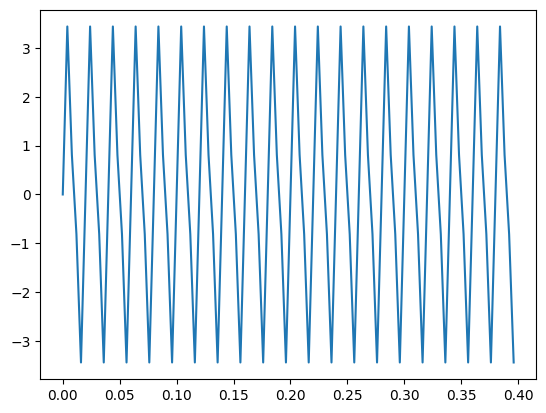

In [200]:
plt.plot(t[:100], sig2[:100])

In [201]:
np.expand_dims(sig1, axis=1)

array([[ 0.        ],
       [ 1.5165829 ],
       [ 2.42754827],
       ...,
       [-2.53539499],
       [-2.42754827],
       [-1.5165829 ]])

In [202]:
sig1 = np.expand_dims(sig1, axis=0)
sig2 = np.expand_dims(sig2, axis=0)
sig1.shape, sig2.shape

((1, 1250), (1, 1250))

In [203]:
sig = np.concatenate((sig1, sig2), axis=0)

In [204]:
sig = np.expand_dims(sig, axis=0)
sig.shape

(1, 2, 1250)

In [205]:
s_epoch = np.tile(sig, (50, 1, 1))
s_epoch.shape, (s_epoch[0, :, :] == s_epoch[10, :, :]).all()

((50, 2, 1250), True)

In [206]:
s_train_epochs = slicer(s_epoch, num_splits=2)

In [207]:
s_train_epochs.shape

(50, 2, 2, 625)

In [208]:
s_no_encoded_train_labels = np.random.randint(0, 3, (50, 1))

In [209]:
mne.set_log_level('warning')
train_feats, test_feats, filtered_data = Preprocess_validator(s_train_epochs, s_no_encoded_train_labels, s_train_epochs, sampling_freq = 250, n_components=2)

The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011005878448486328
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011038541793823242
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.010999679565429688
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011005163192749023
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012004613876342773
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.010001897811889648
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012001514434814453
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012008190155029297
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.009999990463256836
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012001514434814453
The filtered data shape: (100, 2, 625)
Time taken for csp ca

In [210]:
train_feats.shape

(50, 2, 16, 2)

In [211]:
filtered_data.shape

(50, 2, 2, 625)

In [212]:
(filtered_data[0, :, :, :] == filtered_data[10, :, :, :]).all()

True

In [213]:
(filtered_data[:, :, 0, :] == filtered_data[:, :, 0, :]).all()

True

In [214]:
(filtered_data[:, 0, :, :] == filtered_data[:, 1, :, :]).any()

True

In [215]:
(s_train_epochs[:, 0, :, :] == s_train_epochs[:, 1, :, :]).any()

False

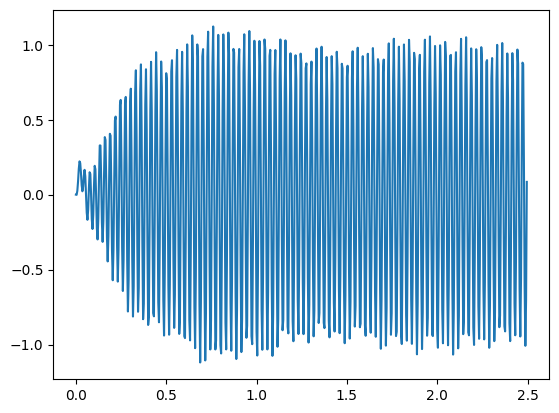

In [216]:
y = filtered_data[0, 1, 0, :]
plt.plot(t[:625], y)

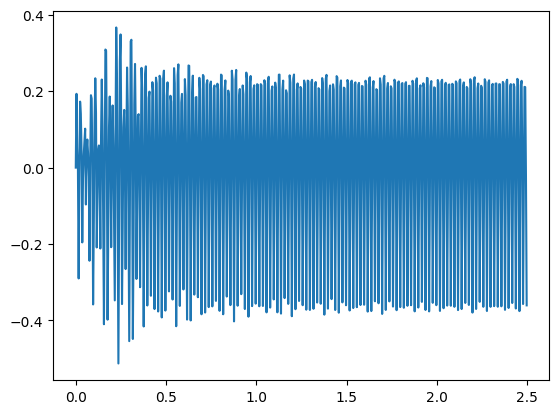

In [217]:
y = filtered_data[0, 0, 1, :]
plt.plot(t[:625], y)

# Heatmap on FBCSP:

In [218]:
with open("train_features_fortestID_[0].pickle", "rb") as f:
    train_features = pickle.load(f)
    f.close()

In [219]:
train_features.shape

(2160, 5, 16, 16)

In [221]:
new_array = np.zeros((2160, 16, 80))

In [222]:
for i in range(5):
    new_array[:, :, 16*i:16*i+16] = train_features[:, i, :, :]
    print((new_array[:, :, 16*i:16*i+16]).shape)

(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)


In [223]:
new_array.shape

(2160, 16, 80)

In [225]:
heat_value = new_array.mean(axis=0)

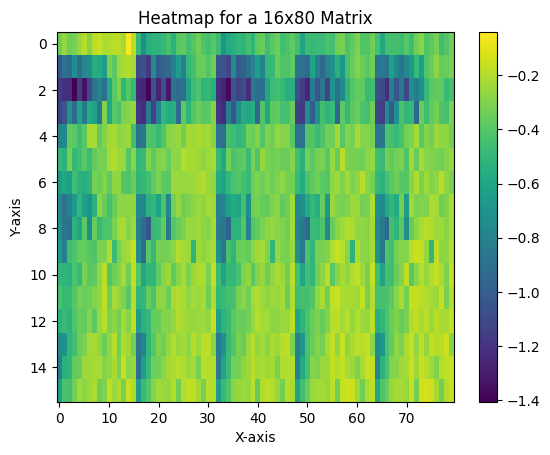

In [226]:
plt.imshow(heat_value, cmap='viridis', aspect='auto')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Heatmap for a 16x80 Matrix')

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()

In [29]:
all_epochs = np.concatenate(all_data_epochs)
all_labels = np.concatenate(no_encode)


mne.set_log_level('warning')
all_features, _ = feature_extraction_cheby2(all_epochs, all_labels, all_epochs, sampling_freq = 250, n_components=16)
#sys.stdout.close()
#sys.stdout = original_stdout


print("All epochs features shape:", all_features.shape)


with open("All_data_features.pickle", "wb") as f:
    pickle.dump(all_features, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()


The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.928704977035522
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.971172571182251
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  11.614934921264648
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.451647520065308
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.614197254180908
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  11.34934687614441
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.473000526428223
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.482449293136597
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.383591890335083
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.589037895202637
The filtered data shape: (12240, 22, 200)
Time take

NameError: name 'train_features' is not defined

In [47]:
new_array = np.zeros((2448, 16, 80))
for i in range(5):
    new_array[:, :, 16*i:16*i+16] = all_features[:, i, :, :]
    print((new_array[:, :, 16*i:16*i+16]).shape)
print("\n\n")
print("new array shape:", new_array.shape)

(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)



new array shape: (2448, 16, 80)


In [30]:
print("All epochs features shape:", all_features.shape)

All epochs features shape: (2448, 5, 16, 16)


In [48]:
epochs_1 = new_array[(all_labels == 0).squeeze(), :, :]
epochs_2 = new_array[(all_labels == 1).squeeze(), :, :]
epochs_3 = new_array[(all_labels == 2).squeeze(), :, :]
epochs_4 = new_array[(all_labels == 3).squeeze(), :, :]


In [49]:
print("Left epochs shape:  ", epochs_1.shape)
print("Right epochs shape: ", epochs_2.shape)
print("Feet epochs shape:  ", epochs_3.shape)
print("Tongue epochs shape:", epochs_4.shape)

Left epochs shape:   (648, 16, 80)
Right epochs shape:  (648, 16, 80)
Feet epochs shape:   (576, 16, 80)
Tongue epochs shape: (576, 16, 80)


In [50]:
epochs_1 = epochs_1.mean(axis=0)
epochs_2 = epochs_2.mean(axis=0)
epochs_3 = epochs_3.mean(axis=0)
epochs_4 = epochs_4.mean(axis=0)

In [62]:
epochs_1

(16, 80)

In [34]:
(all_labels == 0).sum()

648

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 800x1000 with 0 Axes>

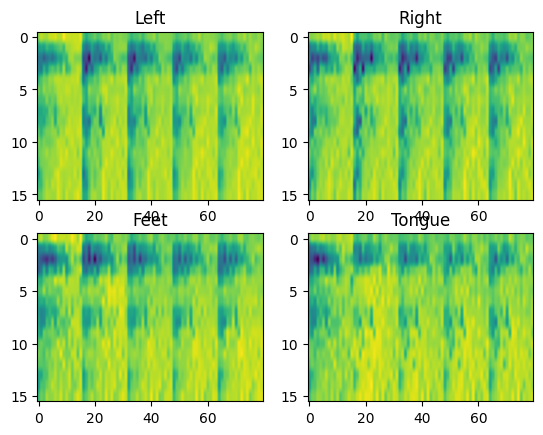

In [59]:
plt.figure(1, (8, 10))
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(epochs_1, cmap='viridis', aspect='auto')
axs[0, 0].set_title("Left")

axs[0, 1].imshow(epochs_2, cmap='viridis', aspect='auto')
axs[0, 1].set_title("Right")

axs[1, 0].imshow(epochs_3, cmap='viridis', aspect='auto')
axs[1, 0].set_title("Feet")

axs[1, 1].imshow(epochs_4, cmap='viridis', aspect='auto')
axs[1, 1].set_title("Tongue")

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()